## Necessary imports for modeling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime

import tensorflow as tf

from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Activation,BatchNormalization,UpSampling2D 
from keras.layers import Dropout,GlobalAveragePooling2D,LeakyReLU,Dense,Reshape, concatenate,Conv2DTranspose
from keras.models import Model,load_model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import TensorBoard
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import load_img, img_to_array
from keras_preprocessing import image
from tensorflow.keras.optimizers import Adam

from numpy import savez_compressed
from numpy import vstack
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import pandas as pd


In [3]:
# Don't pre-allocate memory; allocate as-needed
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));

2023-01-16 03:39:03.220449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 03:39:03.275567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:39:03.365856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:39:03.366786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [4]:
!pwd

/kaggle/working


## Data description
The following was steps were followed:

- Images from the UTKFace dataset were loaded
- The labels of the images were split into 5 columns; image, age, gender, race and Timestamp
- Classes made from the age category
- Categories to be used were serlected

In [5]:
data=[]
for filename in os.listdir('/kaggle/input/utkface/UTKFace'):
    parts=filename.split('_')
    #print(parts[3])
    item={}
    item['image']=filename
    item['age']=parts[0]
    item['gender']=parts[1]
    item['race']=parts[2]
    if (len(parts)==4):
        item['Timestamp']=parts[3]
        data.append(item)

utk_data=pd.DataFrame(data)  
utk_data.describe()  

,image,age,gender,race,Timestamp
count,23705,23705,23705,23705,23705
unique,23705,104,2,5,23479
top,26_0_2_20170104023102422.jpg.chip.jpg,26,0,0,20170110173815028.jpg.chip.jpg
freq,1,2197,12391,10078,7


In [6]:
del utk_data['Timestamp']

In [7]:
def age_cat_fn(age):
    age=int(age)

    if (0<age<18):
        return 0
    elif(18<=age<=25):
        return 1
    elif (25<age<=39):
        return 2
    elif (39< age <=49):
        return 3
    elif (49 < age <=60):
        return 4
    elif age>60:
        return 5    

In [9]:
utk_data['age_cat']=utk_data.age.map(age_cat_fn)

In [10]:
utk_data.to_csv('utk_data.csv',sep=',') 

Split data into two domains


In [11]:
data_A=utk_data[utk_data.age_cat==1]
data_B=utk_data[utk_data.age_cat==4]
print(data_A['age_cat'].count())
print(data_B['age_cat'].count())

3404
2592


In [12]:
image_dir='/kaggle/input/utkface/UTKFace/'
image_paths_A = data_A['image'].tolist()
image_paths_B = data_B['image'].tolist()

print(image_paths_A[:10])

['22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '18_1_0_20170104022856102.jpg.chip.jpg', '24_1_2_20170116173442433.jpg.chip.jpg', '24_1_0_20170119171026777.jpg.chip.jpg', '23_1_0_20170117144822363.jpg.chip.jpg', '23_0_1_20170114033521648.jpg.chip.jpg', '24_1_2_20170116174409602.jpg.chip.jpg', '22_1_1_20170112230703798.jpg.chip.jpg', '25_0_1_20170113145422493.jpg.chip.jpg']


In [13]:
images_A=None
images_B=None
#store 2000 images for A
for i, image_path in enumerate(image_paths_A):
    if (i<2000):
        if (i%1000==0):
            print("processing set A image num "+str(i))
        try:
            # Load image
            loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image)

            # Add another dimension (Add batch dimension)
            loaded_image = np.expand_dims(loaded_image, axis=0)

        # Concatenate all images into one tensor
            if images_A is None:
                images_A = loaded_image
            else:
                images_A = np.concatenate([images_A, loaded_image], axis=0)
        except Exception as e:
            print("Error:", i, e)

#store 2000 images for B
for i, image_path in enumerate(image_paths_B):
    if (i<2000):
        if (i%999==0):
            print("processing set B image num "+str(i))
        try:
            # Load image
            loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image)

            # Add another dimension (Add batch dimension)
            loaded_image = np.expand_dims(loaded_image, axis=0)

            # Concatenate all images into one tensor
            if images_B is None:
                images_B = loaded_image
            else:
                images_B = np.concatenate([images_B, loaded_image], axis=0)
        except Exception as e:
            print("Error:", i, e)   

processing set A image num 0
processing set A image num 1000
processing set B image num 0
processing set B image num 999
processing set B image num 1998


In [14]:
print('images_A :') 
print(images_A.shape)  
print('images_B :')
print(images_B.shape)

images_A :
(2000, 128, 128, 3)
images_B :
(2000, 128, 128, 3)


In [15]:
# save as compressed numpy array
filename = '/kaggle/working/utkface_128.npz'
savez_compressed(filename, images_A, images_B)
print('Saved dataset: ', filename)

Saved dataset:  /kaggle/working/utkface_128.npz


Loaded:  (2000, 128, 128, 3) (2000, 128, 128, 3)


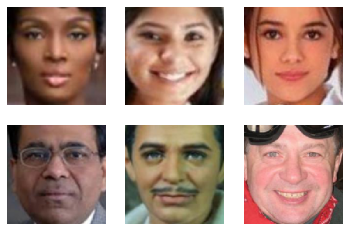

In [16]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('/kaggle/working/utkface_128.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

The images in the two categries added up to 4000 image, with 2000 in each category. The tenors of the images were compressed and saved as `utkface_128.npz`which is used to save multiple arrays to a single file and also compresses the file to save storage space and faster loading time. A sample of images from the dataset was displayed

## Modelling
A Generative Adversarial Network (GAN) is used. It contains 2 parts:
- Generator network
- Discriminator network
The generator network generates fake images and the discriminator checks for the validity of the discriminator network. The process is done multiple times until the generator successfully fools the discriminator
The networks consists of multiple convolution networks, the leaky relu activation function, batchnormalization function and padding. 



In [17]:
# !pip install tensorflow-addons
from keras.initializers import RandomNormal
import tensorflow_addons as tfa

In [18]:
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='same'):
    """
    The function uses the Conv2D class from the Keras library to create a convolutional layer, 
    with the specified number of filters, kernel size, strides, padding, and kernel initialization. 
    It applies this layer to the input tensor, and returns the output tensor.
    """
    return Conv2D(output_dim,kernel_size=ks,strides=s,padding=padding,kernel_initializer=tf.random.truncated_normal(stddev=0.02))(input_)

In [19]:
def lrelu(input_):
    """
    This function uses the LeakyReLU activation function that allows for a small gradient for negative values
    which allows for the weights of the neuron to be  updated.
    """
    return LeakyReLU(alpha=0.2)(input_)

In [20]:
def iNorm(input_):
    """
    The function uses the InstanceNormalization class from the TensorFlow Addons library to 
    create an instance normalization layer. 
    It applies this layer to the input tensor, and returns the output tensor. 
    The axis parameter is set to -1, which indicates that the normalization is applied along the 
    last axis of the input tensor.
    """
    return tfa.layers.InstanceNormalization(axis=-1)(input_)

In [21]:
def build_discriminator(image_shape):
    """
    This function is used to build a discriminator model for a GAN and it takes in an image and 
    outputs a single value indicating the probability that the image is real (as opposed to generated). 
    """
    image_input = Input(shape=image_shape)
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(image_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(x)
    x = iNorm(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(x)
    x = iNorm(x)
    x = LeakyReLU(alpha=0.2)(x)	

    x = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(x)
    x = iNorm(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(x)

    model = Model(inputs=[image_input],outputs=[x])
    # compile model
    model.compile(loss=['mse'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [22]:
disc = build_discriminator(dataB[0].shape)
disc.summary()

2023-01-16 03:45:58.644258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:45:58.645146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:45:58.645810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:45:58.646694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 03:45:58.647387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 32, 32, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       524544

In [23]:
def padd3(input_):
    """
    This function is a helper function that pads the input tensor 
    with a 1 pixel border on all sides using the "REFLECT" padding mode
    The reflect padding mode will help to make the edges look more natural after padding.
    """
    return tf.pad(input_, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

def padd1(input_):
    return tf.pad(input_, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")  

In [24]:
from keras.layers import Add,Lambda
def res_block(input_,nf=64,ks=3,s=1):
    """
    This function is used to create a residual block for a neural network, which is a block that 
    adds the output of a series of layers back to the input allowing the network 
    to learn identity mappings. This can help the network to converge.
    """
    p=int((ks-1)/2)
    y=Lambda(padd1)(input_) #(tf.pad(input_,[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))

    y=Conv2D(filters=nf, kernel_size=ks, strides=s, padding='valid')(y)

    y=iNorm(y)

    y=Lambda(padd1)(y) #(tf.pad(tf.nn.relu(y),[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))

    y=Conv2D(filters=nf, kernel_size=ks, strides=s, padding='valid')(y)

    y1=Add()([y,input_])

    return y1

In [25]:
def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='same'):
    """
    This function is used to increase the spatial resolution of feature maps. 
    """
  
    dcv=Conv2DTranspose(output_dim,(ks,ks),strides=(s,s),padding=padding,kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(input_)

    return dcv

In [26]:
from keras.layers import Lambda,Conv2DTranspose

def build_generator(image_shape):
    """
    This function defines the generator network of the GAN network.
    The generator takes as input an image shape and creates a model with an input layer of the same shape. 
    The input image is passed through several layers of convolutional and transposed convolutional layers 
    with batch normalization and ReLU activation. The generator also uses Residual blocks and Lambda function,
    Residual blocks are used to make the model more robust and Lambda function is used to perform custom operations.
    The output of the last layer is passed through a tanh activation function to produce images with pixel 
    values between -1 and 1. The final model is returned by the function.
    """
    
    nf=64 # num filters for first layer 
    input=Input(shape=image_shape)

    x = Lambda(padd3)(input)
    x = Conv2D(filters=nf, kernel_size=7, strides=1, padding='valid')(x)
    x = iNorm(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nf*2, kernel_size=3, strides=2,padding="same")(x)
    x = iNorm(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nf*4, kernel_size=3, strides=2, padding='same')(x)
    x = iNorm(x)
    x = Activation('relu')(x)

    r1 = res_block(x, nf*4)
    r2 = res_block(r1, nf*4)
    r3 = res_block(r2, nf*4)
    r4 = res_block(r3, nf*4)
    r5 = res_block(r4, nf*4)
    r6 = res_block(r5, nf*4)
    r7 = res_block(r6, nf*4)
    r8 = res_block(r7, nf*4)
    r9 = res_block(r8, nf*4)


    d1=Conv2DTranspose(nf*2, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(r9)

    d1=Activation('relu')(iNorm(d1))

    d2=Conv2DTranspose(nf, (3,3), strides=(2,2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(d1)


    d2=Activation('relu')(iNorm(d2))

    d2 = Lambda(padd3)(d2) #(tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT"))

    d3= Conv2D(filters=3, kernel_size=7, strides=1, padding='valid')(d2)  

    pred=Activation('tanh')(d3)

    model=Model(input,pred)

    return model

In [27]:
gen=build_generator(dataA[0].shape)
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
instance_normalization_3 (Insta (None, 128, 128, 64) 128         conv2d_5[0][0]                   
____________________________________________________________________________________________

In [28]:
def build_composite_model(g_model_1, d_model, g_model_2, image_shape):
    """
    This function combines the two generator models with one discriminator model to train the generator models
    The generator model, g_model_1, takes an input image and generates an output image, 
    which is then passed as input to the discriminator model d_model to produce an output. 
    The g_model_1 is also used to generate an output image from an identity input, 
    representing the case where the input image is passed through the generator model without any change.
    g_model_2 is to generate an output image from the output of g_model_1 (forward cycle) and 
    to generate an output image from the output of g_model_2 itself (backward cycle).
    """
    
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [30]:
def get_subsample(dataset):
    """
    This function is used for data sampling where a smallsubset of the data, is used to train the model.
    The output is a dataset with two outputs, each containing 1000 images
    """
    t1=np.random.randint(900)
    t2=np.random.randint(1200,2000)
    t3=np.random.randint(2500,2800)
    return np.vstack((dataset[0][t1:t1+300],dataset[0][t2:t2+400],dataset[0][t3:t3+300])),np.vstack((dataset[1][t1:t1+300], dataset[1][t2:t2+400],dataset[1][t3:t3+300]))

In [33]:
# Make folders 
!mkdir /kaggle/working/results
!mkdir /kaggle/working/models
!mkdir /kaggle/working/losses

In [34]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y
 
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = '/kaggle/working/models/g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = '/kaggle/working/models/g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
# 

# save the generator models to file
def save_models2(step, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B):
    # save the first generator model
    filename1 = '/kaggle/working/models/g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = '/kaggle/working/models/g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    # save the firs discriminator model A
    filename3 = '/kaggle/working/models/d_model_A_%06d.h5' % (step+1)
    d_model_A.save(filename3)
    # save the first discriminator model B
    filename4 = '/kaggle/working/models/d_model_B_%06d.h5' % (step+1)
    d_model_B.save(filename4)
    print('>Saved: %s , %s , %s and %s' % (filename1, filename2,filename3,filename4))  
  

In [35]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):

    pyplot.figure(
    figsize=(15, 8),
    dpi=120)

    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '/kaggle/working//%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [36]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [54]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size,n_epochs):
    # define properties of the training run
    n_epochs, n_batch, = n_epochs, batch_size
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = get_subsample(dataset)
    gen1_losses = []
    gen2_losses = []
    disA_losses = []
    disB_losses = []
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        gen1_losses.append(gen1_losses)
        gen2_losses.append(gen2_losses)
        disA_losses.append(0.5 * np.add(dA_loss1, dA_loss2))
        disB_losses.append(0.5 * np.add(dB_loss1, dB_loss2))
        
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models2(i, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B)


In [38]:
# load image data
dataset = load_real_samples('/kaggle/working/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = build_generator(image_shape)
# generator: B -> A
g_model_BtoA = build_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Loaded (2000, 128, 128, 3) (2000, 128, 128, 3)


In [39]:
# load image data
dataset = load_real_samples('/kaggle/working/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = build_generator(image_shape)
# generator: B -> A
g_model_BtoA = build_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Loaded (2000, 128, 128, 3) (2000, 128, 128, 3)


Training the model

In [40]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=2,n_epochs=10)

2023-01-16 03:46:20.047718: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-16 03:46:21.716193: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, dA[1.187,0.344] dB[0.727,0.624] g[17.035,19.659]
>2, dA[1.051,0.651] dB[0.753,0.708] g[15.874,18.246]
>3, dA[3.270,0.910] dB[0.517,0.540] g[14.161,15.792]


2023-01-16 03:46:57.994341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:46:58.184141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:46:58.199051: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, dA[1.369,0.635] dB[2.255,0.564] g[14.678,14.228]
>5, dA[0.738,0.755] dB[2.008,0.720] g[13.264,14.823]
>6, dA[0.950,0.989] dB[1.315,0.554] g[11.964,14.262]
>7, dA[0.607,1.476] dB[1.273,0.785] g[11.769,12.242]
>8, dA[2.206,0.796] dB[0.703,1.116] g[10.686,11.329]
>9, dA[0.853,0.367] dB[0.586,1.109] g[10.928,12.724]
>10, dA[0.617,0.383] dB[0.599,0.874] g[10.152,10.631]
>11, dA[0.320,0.280] dB[0.598,0.420] g[9.875,10.577]
>12, dA[0.343,0.429] dB[0.260,0.357] g[9.207,9.606]
>13, dA[0.292,0.323] dB[0.263,0.239] g[8.498,9.040]
>14, dA[0.364,0.420] dB[0.318,0.244] g[9.049,9.482]
>15, dA[0.250,0.424] dB[0.295,0.214] g[7.528,8.652]
>16, dA[0.301,0.245] dB[0.231,0.208] g[8.389,8.504]
>17, dA[0.253,0.177] dB[0.260,0.224] g[6.003,6.554]
>18, dA[0.240,0.274] dB[0.227,0.178] g[7.591,8.567]
>19, dA[0.255,0.233] dB[0.241,0.217] g[6.616,7.195]
>20, dA[0.131,0.230] dB[0.166,0.173] g[6.844,8.440]
>21, dA[0.271,0.234] dB[0.404,0.260] g[10.971,10.686]
>22, dA[0.224,0.174] dB[0.265,0.245] g[6.146,6.346]
>

2023-01-16 03:47:29.555752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:47:29.568781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, dA[0.147,0.188] dB[0.196,0.189] g[5.945,6.631]
>72, dA[0.166,0.168] dB[0.203,0.110] g[4.609,4.842]
>73, dA[0.150,0.185] dB[0.216,0.140] g[7.283,8.394]
>74, dA[0.094,0.123] dB[0.201,0.228] g[5.922,7.675]
>75, dA[0.162,0.235] dB[0.147,0.230] g[6.562,6.775]
>76, dA[0.199,0.139] dB[0.152,0.203] g[5.390,5.626]
>77, dA[0.160,0.117] dB[0.127,0.224] g[5.467,6.746]
>78, dA[0.199,0.104] dB[0.201,0.095] g[8.517,8.058]
>79, dA[0.064,0.069] dB[0.125,0.084] g[6.757,6.427]
>80, dA[0.109,0.230] dB[0.163,0.168] g[5.009,5.099]
>81, dA[0.170,0.077] dB[0.115,0.155] g[4.461,5.033]
>82, dA[0.111,0.272] dB[0.131,0.154] g[5.213,5.928]
>83, dA[0.207,0.160] dB[0.236,0.146] g[8.812,10.202]
>84, dA[0.230,0.094] dB[0.160,0.058] g[5.712,5.977]
>85, dA[0.081,0.208] dB[0.213,0.188] g[5.159,5.578]
>86, dA[0.178,0.141] dB[0.134,0.193] g[4.584,5.125]
>87, dA[0.140,0.210] dB[0.203,0.113] g[5.657,5.766]
>88, dA[0.150,0.206] dB[0.164,0.374] g[5.204,5.636]
>89, dA[0.113,0.176] dB[0.272,0.181] g[4.843,4.767]
>90, dA[0.1

2023-01-16 03:48:03.376500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, dA[0.184,0.186] dB[0.144,0.217] g[5.018,6.172]
>144, dA[0.248,0.129] dB[0.145,0.212] g[5.965,5.901]
>145, dA[0.194,0.186] dB[0.227,0.121] g[4.795,5.030]
>146, dA[0.072,0.109] dB[0.089,0.092] g[4.672,6.042]
>147, dA[0.062,0.067] dB[0.130,0.103] g[5.977,5.599]
>148, dA[0.242,0.227] dB[0.135,0.250] g[4.472,4.767]
>149, dA[0.073,0.249] dB[0.274,0.258] g[5.354,5.288]
>150, dA[0.200,0.102] dB[0.192,0.108] g[6.664,7.442]
>151, dA[0.223,0.106] dB[0.132,0.129] g[4.842,5.688]
>152, dA[0.049,0.325] dB[0.116,0.070] g[5.432,5.087]
>153, dA[0.235,0.064] dB[0.189,0.144] g[4.875,5.391]
>154, dA[0.182,0.144] dB[0.066,0.158] g[4.210,5.440]
>155, dA[0.067,0.126] dB[0.191,0.139] g[7.121,7.645]
>156, dA[0.082,0.170] dB[0.276,0.160] g[7.456,7.935]
>157, dA[0.140,0.074] dB[0.121,0.099] g[6.880,8.150]
>158, dA[0.150,0.138] dB[0.072,0.134] g[6.609,7.578]
>159, dA[0.132,0.090] dB[0.248,0.135] g[5.211,5.539]
>160, dA[0.264,0.216] dB[0.136,0.315] g[4.983,5.155]
>161, dA[0.063,0.184] dB[0.214,0.107] g[6.835,

2023-01-16 03:48:14.313913: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:48:14.327022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>167, dA[0.155,0.080] dB[0.138,0.109] g[5.173,5.296]
>168, dA[0.115,0.162] dB[0.217,0.115] g[5.546,5.600]
>169, dA[0.105,0.105] dB[0.108,0.132] g[8.961,8.133]
>170, dA[0.121,0.109] dB[0.099,0.086] g[8.374,10.388]
>171, dA[0.147,0.055] dB[0.106,0.099] g[6.212,6.920]
>172, dA[0.132,0.280] dB[0.284,0.145] g[6.713,6.687]
>173, dA[0.226,0.082] dB[0.130,0.146] g[6.092,6.267]
>174, dA[0.098,0.196] dB[0.186,0.184] g[5.426,5.413]
>175, dA[0.105,0.125] dB[0.113,0.094] g[5.479,6.062]
>176, dA[0.232,0.118] dB[0.146,0.146] g[4.063,4.621]
>177, dA[0.099,0.336] dB[0.101,0.073] g[5.839,6.078]
>178, dA[0.215,0.110] dB[0.137,0.155] g[4.701,4.873]
>179, dA[0.204,0.151] dB[0.176,0.170] g[4.260,6.616]
>180, dA[0.181,0.139] dB[0.158,0.259] g[5.231,4.665]
>181, dA[0.091,0.065] dB[0.176,0.128] g[6.658,6.682]
>182, dA[0.108,0.241] dB[0.130,0.103] g[7.632,6.690]
>183, dA[0.223,0.222] dB[0.305,0.258] g[4.879,5.716]
>184, dA[0.164,0.181] dB[0.232,0.151] g[5.580,7.304]
>185, dA[0.189,0.086] dB[0.104,0.122] g[5.824

2023-01-16 03:48:32.342835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>205, dA[0.121,0.123] dB[0.142,0.156] g[4.154,4.178]
>206, dA[0.101,0.103] dB[0.105,0.206] g[4.531,5.185]
>207, dA[0.136,0.106] dB[0.257,0.152] g[4.741,5.624]
>208, dA[0.105,0.137] dB[0.205,0.166] g[5.727,6.537]
>209, dA[0.081,0.052] dB[0.147,0.137] g[7.343,8.281]
>210, dA[0.073,0.119] dB[0.179,0.117] g[5.692,6.269]
>211, dA[0.130,0.143] dB[0.167,0.257] g[5.006,5.640]
>212, dA[0.135,0.195] dB[0.187,0.151] g[6.811,6.872]
>213, dA[0.149,0.087] dB[0.199,0.143] g[5.009,6.185]
>214, dA[0.166,0.183] dB[0.130,0.112] g[4.821,5.789]
>215, dA[0.135,0.148] dB[0.181,0.186] g[4.643,5.327]
>216, dA[0.141,0.189] dB[0.183,0.181] g[3.137,3.491]
>217, dA[0.168,0.128] dB[0.139,0.179] g[5.790,6.029]
>218, dA[0.145,0.145] dB[0.247,0.168] g[4.850,5.946]
>219, dA[0.186,0.138] dB[0.130,0.161] g[5.333,5.170]
>220, dA[0.137,0.119] dB[0.121,0.141] g[4.174,4.436]
>221, dA[0.109,0.118] dB[0.169,0.068] g[4.724,6.086]
>222, dA[0.106,0.086] dB[0.161,0.181] g[8.184,9.317]
>223, dA[0.154,0.114] dB[0.102,0.324] g[4.605,

2023-01-16 03:49:03.419372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:49:03.613736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:49:03.627983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>268, dA[0.137,0.090] dB[0.177,0.152] g[4.270,5.023]
>269, dA[0.177,0.203] dB[0.105,0.124] g[5.536,5.329]
>270, dA[0.097,0.064] dB[0.142,0.089] g[5.546,5.747]
>271, dA[0.114,0.107] dB[0.081,0.112] g[5.484,5.856]
>272, dA[0.106,0.105] dB[0.098,0.046] g[6.501,8.176]
>273, dA[0.162,0.084] dB[0.129,0.230] g[7.585,7.684]
>274, dA[0.130,0.277] dB[0.172,0.234] g[5.034,5.958]
>275, dA[0.113,0.099] dB[0.201,0.132] g[4.281,4.918]
>276, dA[0.131,0.136] dB[0.157,0.088] g[5.894,7.074]
>277, dA[0.099,0.065] dB[0.041,0.174] g[6.502,6.394]
>278, dA[0.064,0.089] dB[0.158,0.068] g[6.854,7.236]
>279, dA[0.116,0.174] dB[0.240,0.178] g[6.537,6.748]
>280, dA[0.100,0.053] dB[0.117,0.171] g[5.610,6.760]
>281, dA[0.224,0.132] dB[0.091,0.049] g[4.742,4.951]
>282, dA[0.141,0.096] dB[0.123,0.135] g[4.121,5.685]
>283, dA[0.052,0.140] dB[0.244,0.180] g[5.159,4.941]
>284, dA[0.073,0.044] dB[0.082,0.123] g[5.803,6.775]
>285, dA[0.077,0.122] dB[0.142,0.083] g[4.731,5.031]
>286, dA[0.098,0.075] dB[0.118,0.065] g[7.258,

2023-01-16 03:49:53.299244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>375, dA[0.068,0.202] dB[0.217,0.166] g[4.686,5.250]
>376, dA[0.172,0.051] dB[0.047,0.188] g[4.844,6.230]
>377, dA[0.293,0.312] dB[0.148,0.119] g[5.744,6.289]
>378, dA[0.096,0.045] dB[0.182,0.078] g[4.793,5.442]
>379, dA[0.223,0.074] dB[0.102,0.220] g[6.149,8.389]
>380, dA[0.079,0.415] dB[0.202,0.124] g[4.270,4.314]
>381, dA[0.557,0.178] dB[0.085,0.290] g[5.512,7.180]
>382, dA[0.126,0.131] dB[0.155,0.125] g[5.427,6.338]
>383, dA[0.229,0.143] dB[0.241,0.151] g[4.333,5.936]
>384, dA[0.149,0.116] dB[0.155,0.148] g[3.794,4.092]
>385, dA[0.089,0.182] dB[0.157,0.148] g[4.341,4.784]
>386, dA[0.156,0.159] dB[0.059,0.070] g[5.689,7.190]
>387, dA[0.109,0.106] dB[0.124,0.087] g[7.426,7.502]
>388, dA[0.340,0.283] dB[0.195,0.199] g[4.681,5.118]
>389, dA[0.090,0.129] dB[0.131,0.134] g[3.992,4.119]
>390, dA[0.126,0.279] dB[0.238,0.135] g[4.355,4.901]
>391, dA[0.199,0.110] dB[0.081,0.103] g[4.719,6.017]
>392, dA[0.192,0.222] dB[0.079,0.125] g[6.600,6.762]
>393, dA[0.134,0.102] dB[0.198,0.082] g[5.477,

2023-01-16 03:50:04.286426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:50:04.300611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>399, dA[0.211,0.043] dB[0.062,0.099] g[5.756,6.260]
>400, dA[0.112,0.116] dB[0.141,0.080] g[6.407,6.169]
>401, dA[0.071,0.103] dB[0.111,0.078] g[4.089,4.564]


2023-01-16 03:50:06.084724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>402, dA[0.053,0.090] dB[0.055,0.053] g[7.123,7.713]


2023-01-16 03:50:06.621751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>403, dA[0.127,0.087] dB[0.324,0.130] g[4.608,5.698]
>404, dA[0.048,0.061] dB[0.062,0.206] g[3.762,4.838]
>405, dA[0.183,0.185] dB[0.229,0.131] g[4.797,6.184]
>406, dA[0.155,0.177] dB[0.128,0.188] g[4.393,4.899]
>407, dA[0.115,0.147] dB[0.138,0.139] g[4.806,4.980]
>408, dA[0.141,0.163] dB[0.194,0.199] g[3.980,5.008]
>409, dA[0.185,0.181] dB[0.097,0.149] g[5.927,5.644]
>410, dA[0.142,0.162] dB[0.137,0.051] g[6.434,6.657]
>411, dA[0.124,0.077] dB[0.208,0.103] g[6.002,6.232]
>412, dA[0.062,0.074] dB[0.142,0.260] g[4.146,4.326]
>413, dA[0.076,0.087] dB[0.092,0.093] g[4.340,5.075]
>414, dA[0.195,0.202] dB[0.210,0.155] g[4.127,5.278]
>415, dA[0.173,0.182] dB[0.100,0.185] g[3.426,4.789]
>416, dA[0.075,0.170] dB[0.159,0.123] g[5.010,6.394]
>417, dA[0.173,0.084] dB[0.190,0.113] g[6.272,6.308]
>418, dA[0.146,0.055] dB[0.133,0.077] g[5.298,5.762]
>419, dA[0.051,0.064] dB[0.095,0.076] g[8.362,8.450]
>420, dA[0.039,0.195] dB[0.126,0.191] g[5.284,5.951]
>421, dA[0.182,0.064] dB[0.210,0.098] g[4.159,

2023-01-16 03:50:37.599591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:50:37.621033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:50:38.012702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>467, dA[0.070,0.083] dB[0.194,0.109] g[4.412,4.348]
>468, dA[0.100,0.212] dB[0.098,0.105] g[4.085,4.542]
>469, dA[0.195,0.082] dB[0.080,0.184] g[4.221,5.139]
>470, dA[0.163,0.181] dB[0.334,0.205] g[4.064,3.967]
>471, dA[0.168,0.098] dB[0.115,0.143] g[4.417,5.514]
>472, dA[0.060,0.091] dB[0.127,0.074] g[5.766,6.843]
>473, dA[0.104,0.046] dB[0.137,0.220] g[4.708,5.332]
>474, dA[0.154,0.159] dB[0.114,0.188] g[3.968,4.461]
>475, dA[0.117,0.185] dB[0.186,0.204] g[3.950,4.387]
>476, dA[0.115,0.097] dB[0.153,0.076] g[3.896,4.119]
>477, dA[0.096,0.101] dB[0.271,0.135] g[3.194,3.688]
>478, dA[0.084,0.227] dB[0.207,0.130] g[6.391,6.518]
>479, dA[0.150,0.112] dB[0.094,0.206] g[3.687,4.506]
>480, dA[0.178,0.222] dB[0.084,0.116] g[3.451,3.967]
>481, dA[0.113,0.111] dB[0.255,0.243] g[5.546,6.042]
>482, dA[0.384,0.131] dB[0.237,0.127] g[5.496,4.754]
>483, dA[0.155,0.419] dB[0.231,0.222] g[4.693,5.236]
>484, dA[0.047,0.057] dB[0.166,0.064] g[5.626,5.813]
>485, dA[0.295,0.081] dB[0.088,0.173] g[4.213,

2023-01-16 03:50:59.344374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:50:59.356764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>514, dA[0.154,0.178] dB[0.162,0.210] g[4.156,5.229]
>515, dA[0.079,0.097] dB[0.230,0.227] g[3.992,5.042]
>516, dA[0.114,0.157] dB[0.151,0.121] g[4.178,4.624]
>517, dA[0.182,0.144] dB[0.173,0.139] g[6.167,6.555]
>518, dA[0.114,0.099] dB[0.092,0.067] g[6.070,5.814]
>519, dA[0.159,0.242] dB[0.096,0.221] g[4.393,5.044]
>520, dA[0.135,0.120] dB[0.217,0.160] g[4.337,6.207]
>521, dA[0.124,0.166] dB[0.156,0.130] g[5.467,5.183]
>522, dA[0.085,0.194] dB[0.109,0.114] g[6.714,5.964]
>523, dA[0.150,0.076] dB[0.214,0.102] g[4.165,4.901]
>524, dA[0.122,0.130] dB[0.094,0.237] g[3.893,4.868]
>525, dA[0.057,0.037] dB[0.157,0.111] g[4.360,5.069]
>526, dA[0.096,0.112] dB[0.083,0.124] g[3.846,4.300]
>527, dA[0.119,0.175] dB[0.212,0.086] g[5.286,4.740]
>528, dA[0.187,0.141] dB[0.053,0.165] g[4.403,4.877]
>529, dA[0.024,0.079] dB[0.162,0.076] g[5.423,5.509]
>530, dA[0.117,0.193] dB[0.159,0.238] g[5.225,5.614]
>531, dA[0.174,0.080] dB[0.134,0.053] g[5.227,6.529]
>532, dA[0.051,0.116] dB[0.071,0.060] g[7.921,

2023-01-16 03:51:08.919162: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>534, dA[0.117,0.206] dB[0.137,0.110] g[4.395,4.304]


2023-01-16 03:51:09.454622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:51:09.652677: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>535, dA[0.093,0.048] dB[0.059,0.088] g[4.028,4.689]
>536, dA[0.113,0.150] dB[0.146,0.097] g[4.724,5.871]
>537, dA[0.177,0.125] dB[0.121,0.171] g[7.269,7.653]
>538, dA[0.148,0.102] dB[0.104,0.056] g[4.986,4.834]
>539, dA[0.131,0.196] dB[0.225,0.220] g[5.033,5.238]
>540, dA[0.195,0.093] dB[0.219,0.059] g[4.523,5.510]
>541, dA[0.088,0.246] dB[0.096,0.167] g[4.056,4.365]
>542, dA[0.169,0.045] dB[0.171,0.066] g[4.016,4.039]
>543, dA[0.105,0.056] dB[0.063,0.121] g[5.084,6.044]
>544, dA[0.079,0.275] dB[0.119,0.094] g[3.545,3.713]
>545, dA[0.203,0.082] dB[0.061,0.091] g[4.725,5.097]
>546, dA[0.275,0.146] dB[0.118,0.150] g[4.818,5.849]
>547, dA[0.063,0.178] dB[0.132,0.207] g[4.547,4.819]
>548, dA[0.291,0.098] dB[0.232,0.127] g[4.566,4.523]
>549, dA[0.117,0.113] dB[0.153,0.246] g[4.344,5.627]
>550, dA[0.149,0.026] dB[0.044,0.077] g[5.777,7.122]
>551, dA[0.027,0.150] dB[0.174,0.194] g[5.348,5.799]
>552, dA[0.154,0.054] dB[0.181,0.083] g[5.151,5.222]
>553, dA[0.219,0.288] dB[0.090,0.057] g[7.675,

2023-01-16 03:51:32.417744: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>584, dA[0.148,0.054] dB[0.110,0.180] g[3.838,4.708]
>585, dA[0.092,0.211] dB[0.121,0.080] g[4.989,5.607]
>586, dA[0.084,0.075] dB[0.136,0.122] g[5.258,5.843]
>587, dA[0.105,0.114] dB[0.252,0.110] g[4.509,4.597]
>588, dA[0.087,0.111] dB[0.088,0.130] g[3.589,4.603]
>589, dA[0.158,0.238] dB[0.102,0.146] g[4.581,5.127]
>590, dA[0.074,0.095] dB[0.051,0.100] g[4.751,5.862]
>591, dA[0.305,0.143] dB[0.118,0.113] g[4.402,5.310]
>592, dA[0.056,0.104] dB[0.208,0.110] g[4.793,5.267]
>593, dA[0.061,0.079] dB[0.092,0.177] g[7.473,7.125]
>594, dA[0.095,0.057] dB[0.143,0.047] g[4.882,4.988]
>595, dA[0.086,0.149] dB[0.160,0.240] g[4.864,4.511]
>596, dA[0.107,0.173] dB[0.152,0.135] g[3.615,5.497]
>597, dA[0.212,0.070] dB[0.126,0.093] g[3.975,4.059]
>598, dA[0.045,0.219] dB[0.123,0.051] g[5.355,6.337]
>599, dA[0.115,0.075] dB[0.150,0.111] g[4.451,5.757]
>600, dA[0.111,0.054] dB[0.086,0.096] g[6.396,6.857]


2023-01-16 03:51:40.346966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:51:40.555140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>601, dA[0.044,0.051] dB[0.046,0.152] g[5.775,6.460]
>602, dA[0.156,0.325] dB[0.277,0.172] g[4.479,4.551]
>603, dA[0.085,0.055] dB[0.153,0.056] g[4.239,4.093]
>604, dA[0.171,0.114] dB[0.030,0.104] g[4.459,5.592]
>605, dA[0.086,0.106] dB[0.260,0.151] g[4.250,4.781]
>606, dA[0.040,0.083] dB[0.130,0.111] g[5.521,5.348]
>607, dA[0.074,0.056] dB[0.084,0.163] g[4.027,4.203]
>608, dA[0.105,0.191] dB[0.045,0.044] g[4.151,3.925]
>609, dA[0.177,0.137] dB[0.227,0.080] g[5.103,5.519]
>610, dA[0.102,0.085] dB[0.145,0.162] g[5.025,5.333]
>611, dA[0.154,0.124] dB[0.045,0.114] g[3.752,4.020]
>612, dA[0.050,0.067] dB[0.076,0.031] g[5.278,5.526]
>613, dA[0.192,0.198] dB[0.264,0.262] g[5.301,4.949]
>614, dA[0.156,0.059] dB[0.092,0.254] g[4.017,5.886]
>615, dA[0.088,0.074] dB[0.320,0.176] g[5.705,6.877]
>616, dA[0.106,0.079] dB[0.051,0.093] g[5.976,7.401]
>617, dA[0.103,0.125] dB[0.171,0.110] g[5.294,6.085]
>618, dA[0.217,0.153] dB[0.100,0.117] g[5.746,5.956]
>619, dA[0.091,0.234] dB[0.283,0.123] g[4.665,

2023-01-16 03:51:54.251481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:51:54.438862: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>630, dA[0.118,0.112] dB[0.059,0.028] g[5.256,5.419]
>631, dA[0.054,0.100] dB[0.255,0.147] g[5.243,5.992]
>632, dA[0.317,0.033] dB[0.058,0.187] g[4.341,5.385]
>633, dA[0.048,0.127] dB[0.038,0.041] g[4.467,6.386]
>634, dA[0.098,0.139] dB[0.191,0.106] g[5.805,5.632]
>635, dA[0.065,0.073] dB[0.086,0.054] g[5.711,6.452]
>636, dA[0.066,0.065] dB[0.097,0.171] g[6.826,7.593]
>637, dA[0.232,0.120] dB[0.081,0.082] g[3.759,5.383]
>638, dA[0.079,0.142] dB[0.137,0.100] g[5.180,5.168]
>639, dA[0.088,0.227] dB[0.105,0.126] g[3.913,4.493]
>640, dA[0.105,0.043] dB[0.165,0.187] g[5.057,5.574]
>641, dA[0.171,0.111] dB[0.044,0.067] g[4.979,5.446]
>642, dA[0.066,0.124] dB[0.204,0.037] g[5.044,4.425]
>643, dA[0.101,0.081] dB[0.104,0.135] g[4.309,4.532]
>644, dA[0.195,0.155] dB[0.027,0.113] g[3.962,4.750]
>645, dA[0.057,0.042] dB[0.216,0.052] g[4.742,4.455]
>646, dA[0.146,0.208] dB[0.181,0.153] g[5.064,5.256]
>647, dA[0.034,0.140] dB[0.095,0.112] g[5.147,5.821]
>648, dA[0.133,0.099] dB[0.083,0.140] g[5.236,

2023-01-16 03:52:11.559962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>663, dA[0.219,0.137] dB[0.095,0.069] g[4.008,4.686]


2023-01-16 03:52:11.869003: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:52:12.083793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>664, dA[0.047,0.171] dB[0.166,0.071] g[5.341,4.487]
>665, dA[0.109,0.254] dB[0.347,0.166] g[4.192,3.839]
>666, dA[0.301,0.050] dB[0.067,0.377] g[4.244,6.010]
>667, dA[0.125,0.120] dB[0.148,0.046] g[4.481,4.371]
>668, dA[0.070,0.106] dB[0.222,0.173] g[4.751,5.006]
>669, dA[0.129,0.087] dB[0.137,0.229] g[5.569,5.959]
>670, dA[0.035,0.125] dB[0.093,0.066] g[5.438,6.410]
>671, dA[0.156,0.057] dB[0.225,0.155] g[5.644,6.232]
>672, dA[0.080,0.023] dB[0.053,0.069] g[7.073,7.392]
>673, dA[0.053,0.178] dB[0.297,0.091] g[3.910,3.617]
>674, dA[0.063,0.133] dB[0.212,0.144] g[4.164,3.740]
>675, dA[0.187,0.113] dB[0.059,0.142] g[3.396,4.220]
>676, dA[0.054,0.130] dB[0.094,0.071] g[4.088,4.237]
>677, dA[0.049,0.072] dB[0.216,0.174] g[4.176,4.499]
>678, dA[0.308,0.236] dB[0.033,0.136] g[3.900,5.081]
>679, dA[0.071,0.083] dB[0.213,0.134] g[3.728,5.376]
>680, dA[0.174,0.212] dB[0.202,0.114] g[5.022,5.007]
>681, dA[0.183,0.108] dB[0.083,0.159] g[3.550,4.165]
>682, dA[0.092,0.096] dB[0.122,0.125] g[4.623,

2023-01-16 03:52:27.476191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>697, dA[0.093,0.101] dB[0.148,0.184] g[3.315,3.829]
>698, dA[0.118,0.051] dB[0.133,0.215] g[4.359,4.795]
>699, dA[0.170,0.201] dB[0.145,0.068] g[4.973,5.192]
>700, dA[0.098,0.079] dB[0.177,0.157] g[3.752,4.061]
>701, dA[0.088,0.045] dB[0.106,0.150] g[5.199,7.952]
>702, dA[0.146,0.300] dB[0.119,0.155] g[6.032,6.128]
>703, dA[0.114,0.092] dB[0.098,0.039] g[5.503,6.179]
>704, dA[0.104,0.130] dB[0.295,0.080] g[4.293,4.420]
>705, dA[0.149,0.072] dB[0.064,0.101] g[5.232,5.482]
>706, dA[0.041,0.160] dB[0.085,0.096] g[3.654,3.732]
>707, dA[0.171,0.052] dB[0.063,0.080] g[6.383,6.342]
>708, dA[0.100,0.130] dB[0.120,0.165] g[3.921,4.449]
>709, dA[0.057,0.102] dB[0.243,0.159] g[4.275,4.745]
>710, dA[0.167,0.074] dB[0.147,0.189] g[5.462,5.081]
>711, dA[0.048,0.242] dB[0.108,0.104] g[4.789,4.806]
>712, dA[0.070,0.054] dB[0.094,0.173] g[6.003,6.873]
>713, dA[0.190,0.106] dB[0.197,0.107] g[3.860,4.154]
>714, dA[0.183,0.260] dB[0.176,0.151] g[4.450,5.048]
>715, dA[0.081,0.149] dB[0.097,0.115] g[3.862,

2023-01-16 03:52:38.273270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>720, dA[0.077,0.266] dB[0.295,0.205] g[4.438,5.851]
>721, dA[0.286,0.084] dB[0.066,0.097] g[3.961,4.448]
>722, dA[0.080,0.172] dB[0.202,0.102] g[4.889,5.333]
>723, dA[0.162,0.178] dB[0.085,0.160] g[5.836,7.595]
>724, dA[0.145,0.042] dB[0.067,0.040] g[5.771,6.589]
>725, dA[0.090,0.176] dB[0.110,0.108] g[4.243,4.713]
>726, dA[0.121,0.066] dB[0.059,0.119] g[2.881,3.564]
>727, dA[0.170,0.271] dB[0.109,0.123] g[3.636,3.811]
>728, dA[0.088,0.185] dB[0.211,0.189] g[5.089,4.902]
>729, dA[0.121,0.095] dB[0.159,0.122] g[4.745,5.795]
>730, dA[0.278,0.118] dB[0.188,0.240] g[4.279,5.389]


2023-01-16 03:52:43.389536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:52:43.598309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:52:43.611178: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>731, dA[0.095,0.182] dB[0.150,0.090] g[4.345,4.314]
>732, dA[0.119,0.082] dB[0.155,0.161] g[5.086,5.028]
>733, dA[0.075,0.079] dB[0.101,0.108] g[4.997,6.680]
>734, dA[0.059,0.112] dB[0.137,0.060] g[4.395,4.623]
>735, dA[0.142,0.058] dB[0.099,0.076] g[3.875,6.117]
>736, dA[0.118,0.120] dB[0.087,0.174] g[4.037,4.779]
>737, dA[0.169,0.246] dB[0.136,0.119] g[3.959,4.659]
>738, dA[0.071,0.096] dB[0.109,0.131] g[4.863,5.319]
>739, dA[0.076,0.061] dB[0.085,0.088] g[5.070,5.466]
>740, dA[0.103,0.182] dB[0.132,0.051] g[5.937,5.633]
>741, dA[0.206,0.132] dB[0.104,0.195] g[4.714,6.118]
>742, dA[0.136,0.076] dB[0.123,0.109] g[4.079,3.756]


2023-01-16 03:52:49.112624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>743, dA[0.040,0.104] dB[0.120,0.067] g[5.416,7.385]
>744, dA[0.073,0.111] dB[0.075,0.149] g[5.154,6.893]
>745, dA[0.062,0.052] dB[0.102,0.039] g[5.737,5.555]
>746, dA[0.037,0.135] dB[0.179,0.164] g[5.026,6.048]
>747, dA[0.190,0.032] dB[0.133,0.129] g[4.141,7.302]
>748, dA[0.174,0.077] dB[0.055,0.111] g[4.013,5.278]
>749, dA[0.052,0.122] dB[0.117,0.111] g[4.234,4.490]
>750, dA[0.037,0.035] dB[0.075,0.022] g[4.672,4.510]
>751, dA[0.068,0.281] dB[0.178,0.098] g[4.369,4.665]
>752, dA[0.082,0.037] dB[0.055,0.048] g[4.133,5.427]
>753, dA[0.160,0.305] dB[0.135,0.120] g[3.677,4.301]
>754, dA[0.099,0.050] dB[0.054,0.184] g[5.341,6.072]
>755, dA[0.150,0.124] dB[0.157,0.117] g[4.835,5.256]
>756, dA[0.242,0.114] dB[0.179,0.160] g[4.288,5.211]
>757, dA[0.104,0.246] dB[0.151,0.138] g[3.001,3.500]
>758, dA[0.164,0.041] dB[0.042,0.204] g[3.742,4.713]
>759, dA[0.080,0.225] dB[0.283,0.051] g[4.035,4.034]
>760, dA[0.136,0.098] dB[0.199,0.317] g[5.414,6.822]
>761, dA[0.149,0.145] dB[0.125,0.076] g[6.577,

2023-01-16 03:53:00.221213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>767, dA[0.111,0.122] dB[0.220,0.103] g[4.345,4.748]
>768, dA[0.094,0.078] dB[0.054,0.045] g[4.566,5.268]
>769, dA[0.065,0.195] dB[0.168,0.187] g[3.343,3.896]
>770, dA[0.197,0.025] dB[0.072,0.059] g[4.765,5.953]
>771, dA[0.094,0.318] dB[0.082,0.074] g[4.215,5.828]
>772, dA[0.262,0.040] dB[0.043,0.150] g[4.361,6.118]
>773, dA[0.099,0.089] dB[0.343,0.164] g[4.050,4.642]
>774, dA[0.045,0.072] dB[0.165,0.120] g[5.715,6.094]
>775, dA[0.035,0.078] dB[0.041,0.089] g[4.284,5.186]
>776, dA[0.392,0.154] dB[0.135,0.070] g[3.983,3.774]
>777, dA[0.081,0.076] dB[0.040,0.097] g[4.253,5.094]
>778, dA[0.070,0.110] dB[0.131,0.126] g[6.591,6.958]
>779, dA[0.041,0.138] dB[0.211,0.082] g[5.045,7.570]
>780, dA[0.173,0.029] dB[0.085,0.159] g[4.593,6.078]
>781, dA[0.101,0.242] dB[0.208,0.183] g[4.933,4.738]
>782, dA[0.064,0.025] dB[0.089,0.071] g[4.397,4.693]
>783, dA[0.254,0.284] dB[0.208,0.120] g[3.861,4.110]
>784, dA[0.059,0.135] dB[0.154,0.311] g[4.365,4.631]
>785, dA[0.319,0.099] dB[0.140,0.146] g[4.839,

2023-01-16 03:53:14.693635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>798, dA[0.041,0.158] dB[0.167,0.109] g[4.145,4.630]


2023-01-16 03:53:15.024868: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>799, dA[0.114,0.069] dB[0.089,0.122] g[3.574,3.833]
>800, dA[0.069,0.067] dB[0.100,0.150] g[5.459,5.918]
>801, dA[0.153,0.118] dB[0.150,0.210] g[4.718,5.295]
>802, dA[0.079,0.105] dB[0.072,0.047] g[5.796,5.535]
>803, dA[0.091,0.099] dB[0.069,0.053] g[5.632,5.269]
>804, dA[0.103,0.149] dB[0.230,0.116] g[6.465,7.310]
>805, dA[0.081,0.041] dB[0.261,0.141] g[3.631,3.817]
>806, dA[0.021,0.122] dB[0.267,0.134] g[4.631,4.838]
>807, dA[0.223,0.047] dB[0.066,0.161] g[4.356,5.593]
>808, dA[0.050,0.169] dB[0.218,0.085] g[5.710,5.773]
>809, dA[0.055,0.064] dB[0.166,0.056] g[5.766,5.466]
>810, dA[0.074,0.128] dB[0.139,0.159] g[3.914,5.121]
>811, dA[0.077,0.056] dB[0.040,0.079] g[4.670,5.248]
>812, dA[0.038,0.050] dB[0.115,0.059] g[5.679,5.751]
>813, dA[0.124,0.027] dB[0.094,0.064] g[5.476,7.335]
>814, dA[0.062,0.173] dB[0.145,0.128] g[6.788,8.660]


2023-01-16 03:53:22.418976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>815, dA[0.167,0.057] dB[0.068,0.092] g[5.121,5.692]
>816, dA[0.090,0.165] dB[0.197,0.152] g[4.811,5.685]
>817, dA[0.044,0.021] dB[0.052,0.091] g[4.620,5.597]
>818, dA[0.185,0.109] dB[0.056,0.062] g[3.890,4.895]
>819, dA[0.072,0.070] dB[0.168,0.064] g[7.048,7.874]
>820, dA[0.134,0.037] dB[0.093,0.210] g[4.400,5.885]
>821, dA[0.194,0.159] dB[0.154,0.043] g[4.322,4.716]
>822, dA[0.070,0.215] dB[0.086,0.135] g[4.840,4.593]
>823, dA[0.058,0.081] dB[0.059,0.055] g[4.117,4.580]
>824, dA[0.236,0.093] dB[0.100,0.143] g[4.056,4.562]
>825, dA[0.106,0.181] dB[0.227,0.176] g[3.859,3.715]
>826, dA[0.112,0.119] dB[0.070,0.133] g[3.603,4.284]
>827, dA[0.160,0.049] dB[0.031,0.043] g[6.767,5.942]
>828, dA[0.242,0.125] dB[0.132,0.198] g[3.332,4.084]
>829, dA[0.050,0.170] dB[0.189,0.055] g[4.903,4.717]
>830, dA[0.070,0.026] dB[0.045,0.080] g[4.868,5.434]
>831, dA[0.183,0.165] dB[0.275,0.083] g[4.687,4.436]
>832, dA[0.039,0.129] dB[0.153,0.345] g[4.743,5.028]
>833, dA[0.249,0.086] dB[0.080,0.116] g[3.783,

2023-01-16 03:53:44.415445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:53:44.428131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>858, dA[0.305,0.103] dB[0.076,0.280] g[5.051,5.740]
>859, dA[0.207,0.139] dB[0.256,0.139] g[5.773,6.573]
>860, dA[0.118,0.221] dB[0.059,0.114] g[4.579,5.836]
>861, dA[0.145,0.070] dB[0.066,0.110] g[4.946,5.452]


2023-01-16 03:53:46.273600: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>862, dA[0.052,0.129] dB[0.291,0.136] g[4.216,4.541]
>863, dA[0.145,0.085] dB[0.145,0.198] g[3.769,4.515]
>864, dA[0.077,0.056] dB[0.087,0.165] g[6.373,6.702]
>865, dA[0.118,0.124] dB[0.172,0.056] g[5.685,6.454]
>866, dA[0.016,0.095] dB[0.208,0.255] g[4.863,4.442]
>867, dA[0.273,0.139] dB[0.098,0.127] g[3.428,4.377]
>868, dA[0.090,0.054] dB[0.136,0.091] g[5.260,5.730]
>869, dA[0.086,0.128] dB[0.158,0.112] g[3.550,4.674]
>870, dA[0.135,0.054] dB[0.047,0.093] g[4.710,4.899]
>871, dA[0.027,0.040] dB[0.067,0.037] g[5.212,6.062]
>872, dA[0.113,0.090] dB[0.107,0.140] g[3.568,4.388]
>873, dA[0.132,0.052] dB[0.077,0.037] g[4.183,4.818]
>874, dA[0.059,0.175] dB[0.045,0.092] g[5.135,5.707]
>875, dA[0.073,0.098] dB[0.190,0.122] g[3.471,3.388]
>876, dA[0.116,0.025] dB[0.058,0.088] g[5.683,6.740]
>877, dA[0.026,0.160] dB[0.305,0.169] g[5.066,5.219]
>878, dA[0.031,0.040] dB[0.124,0.180] g[4.640,5.030]
>879, dA[0.255,0.107] dB[0.088,0.100] g[5.016,6.569]
>880, dA[0.077,0.050] dB[0.061,0.088] g[3.425,

2023-01-16 03:54:24.074159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>942, dA[0.147,0.180] dB[0.107,0.072] g[5.024,4.219]
>943, dA[0.169,0.108] dB[0.092,0.089] g[5.791,5.775]
>944, dA[0.106,0.162] dB[0.122,0.146] g[4.321,5.242]
>945, dA[0.068,0.148] dB[0.105,0.077] g[5.473,7.759]
>946, dA[0.106,0.086] dB[0.083,0.087] g[5.635,6.615]
>947, dA[0.116,0.068] dB[0.067,0.115] g[4.779,5.866]
>948, dA[0.092,0.127] dB[0.270,0.109] g[4.159,4.550]
>949, dA[0.074,0.146] dB[0.117,0.148] g[4.074,3.946]
>950, dA[0.075,0.076] dB[0.080,0.061] g[5.441,5.788]
>951, dA[0.109,0.169] dB[0.185,0.125] g[5.063,5.027]
>952, dA[0.068,0.057] dB[0.071,0.121] g[4.710,5.372]
>953, dA[0.082,0.064] dB[0.076,0.073] g[4.805,5.223]
>954, dA[0.045,0.138] dB[0.175,0.085] g[3.659,3.320]
>955, dA[0.035,0.030] dB[0.028,0.094] g[3.839,5.797]
>956, dA[0.136,0.047] dB[0.046,0.137] g[5.902,6.558]
>957, dA[0.049,0.037] dB[0.309,0.087] g[4.649,5.123]
>958, dA[0.082,0.172] dB[0.108,0.081] g[4.309,4.827]
>959, dA[0.144,0.214] dB[0.179,0.152] g[3.099,3.366]
>960, dA[0.120,0.108] dB[0.110,0.127] g[4.914,

2023-01-16 03:54:48.431898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>995, dA[0.119,0.121] dB[0.224,0.123] g[4.665,5.428]


2023-01-16 03:54:48.979508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:54:49.175635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:54:49.190586: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>996, dA[0.272,0.189] dB[0.101,0.196] g[4.633,5.059]
>997, dA[0.166,0.118] dB[0.114,0.128] g[5.495,5.293]
>998, dA[0.104,0.127] dB[0.139,0.169] g[4.547,4.908]
>999, dA[0.083,0.144] dB[0.166,0.081] g[5.675,5.987]
>1000, dA[0.088,0.058] dB[0.129,0.095] g[4.430,4.435]
>1001, dA[0.146,0.282] dB[0.151,0.114] g[5.092,5.945]
>1002, dA[0.126,0.098] dB[0.050,0.120] g[5.122,5.028]
>1003, dA[0.180,0.037] dB[0.154,0.138] g[3.920,5.563]
>1004, dA[0.190,0.124] dB[0.133,0.130] g[3.470,3.622]
>1005, dA[0.066,0.184] dB[0.168,0.114] g[4.202,4.534]
>1006, dA[0.174,0.051] dB[0.120,0.164] g[4.869,5.813]
>1007, dA[0.113,0.124] dB[0.133,0.053] g[4.275,4.646]
>1008, dA[0.111,0.166] dB[0.174,0.318] g[3.971,4.964]
>1009, dA[0.084,0.110] dB[0.100,0.052] g[4.949,5.022]
>1010, dA[0.106,0.052] dB[0.092,0.100] g[5.689,6.680]
>1011, dA[0.079,0.066] dB[0.146,0.081] g[4.447,5.894]
>1012, dA[0.042,0.147] dB[0.121,0.154] g[3.167,3.297]
>1013, dA[0.149,0.193] dB[0.170,0.180] g[3.849,4.550]
>1014, dA[0.155,0.072] dB[0.053,

2023-01-16 03:55:01.302976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:55:01.315908: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1022, dA[0.425,0.240] dB[0.188,0.206] g[5.550,6.786]
>1023, dA[0.129,0.210] dB[0.123,0.111] g[4.892,4.453]
>1024, dA[0.130,0.156] dB[0.223,0.306] g[3.526,4.421]
>1025, dA[0.153,0.142] dB[0.097,0.077] g[4.506,5.467]
>1026, dA[0.098,0.092] dB[0.107,0.098] g[4.637,5.243]
>1027, dA[0.130,0.077] dB[0.166,0.136] g[3.761,4.070]
>1028, dA[0.049,0.114] dB[0.067,0.148] g[4.548,5.111]
>1029, dA[0.176,0.117] dB[0.128,0.088] g[3.648,4.509]
>1030, dA[0.153,0.063] dB[0.104,0.124] g[4.111,4.382]
>1031, dA[0.245,0.377] dB[0.139,0.085] g[3.561,4.098]
>1032, dA[0.227,0.140] dB[0.080,0.042] g[4.759,5.341]
>1033, dA[0.242,0.115] dB[0.089,0.092] g[3.615,5.330]
>1034, dA[0.103,0.313] dB[0.085,0.059] g[3.582,4.023]
>1035, dA[0.265,0.097] dB[0.047,0.141] g[4.285,5.538]
>1036, dA[0.152,0.181] dB[0.099,0.121] g[3.603,4.162]
>1037, dA[0.098,0.170] dB[0.182,0.169] g[4.563,4.471]
>1038, dA[0.214,0.133] dB[0.288,0.166] g[3.904,4.046]
>1039, dA[0.282,0.080] dB[0.106,0.258] g[4.662,4.767]
>1040, dA[0.068,0.152] dB[0.

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: /kaggle/working/models/g_model_AtoB_001050.h5 , /kaggle/working/models/g_model_BtoA_001050.h5 , /kaggle/working/models/d_model_A_001050.h5 and /kaggle/working/models/d_model_B_001050.h5
>1051, dA[0.125,0.097] dB[0.145,0.129] g[4.390,4.435]
>1052, dA[0.067,0.110] dB[0.095,0.096] g[4.489,5.106]
>1053, dA[0.190,0.115] dB[0.046,0.152] g[4.046,4.965]
>1054, dA[0.073,0.136] dB[0.241,0.054] g[5.091,5.309]
>1055, dA[0.093,0.235] dB[0.122,0.138] g[5.368,5.289]
>1056, dA[0.215,0.085] dB[0.173,0.155] g[4.716,4.692]
>1057, dA[0.121,0.132] dB[0.088,0.172] g[4.710,4.885]


2023-01-16 03:55:20.194594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1058, dA[0.129,0.073] dB[0.111,0.087] g[4.290,5.389]


2023-01-16 03:55:20.541545: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:55:20.749588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1059, dA[0.161,0.191] dB[0.083,0.072] g[4.701,4.693]
>1060, dA[0.091,0.163] dB[0.097,0.095] g[5.402,6.491]
>1061, dA[0.155,0.133] dB[0.112,0.185] g[4.578,5.490]
>1062, dA[0.105,0.174] dB[0.063,0.052] g[5.697,6.835]
>1063, dA[0.092,0.030] dB[0.170,0.115] g[4.456,4.567]
>1064, dA[0.137,0.058] dB[0.054,0.097] g[4.358,4.780]
>1065, dA[0.112,0.320] dB[0.140,0.130] g[3.836,4.519]
>1066, dA[0.091,0.061] dB[0.033,0.104] g[3.632,4.778]
>1067, dA[0.163,0.108] dB[0.223,0.052] g[4.350,4.838]
>1068, dA[0.068,0.094] dB[0.092,0.273] g[3.972,4.162]
>1069, dA[0.097,0.052] dB[0.084,0.042] g[3.834,4.389]
>1070, dA[0.081,0.156] dB[0.082,0.099] g[3.861,4.755]
>1071, dA[0.130,0.155] dB[0.224,0.112] g[4.928,5.282]
>1072, dA[0.162,0.117] dB[0.057,0.095] g[4.829,5.209]
>1073, dA[0.093,0.060] dB[0.043,0.069] g[3.771,4.723]
>1074, dA[0.046,0.092] dB[0.132,0.085] g[3.842,4.207]
>1075, dA[0.036,0.052] dB[0.071,0.122] g[4.193,5.310]
>1076, dA[0.069,0.086] dB[0.163,0.058] g[4.466,3.978]
>1077, dA[0.034,0.031] dB[0.

2023-01-16 03:55:34.454993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1088, dA[0.139,0.235] dB[0.235,0.137] g[4.413,4.850]
>1089, dA[0.106,0.030] dB[0.121,0.106] g[5.945,5.721]
>1090, dA[0.227,0.194] dB[0.135,0.140] g[3.768,4.703]
>1091, dA[0.056,0.133] dB[0.152,0.101] g[4.383,4.392]
>1092, dA[0.085,0.036] dB[0.115,0.105] g[4.318,4.813]
>1093, dA[0.073,0.114] dB[0.111,0.090] g[4.757,5.991]
>1094, dA[0.095,0.065] dB[0.115,0.163] g[4.652,5.486]
>1095, dA[0.036,0.076] dB[0.134,0.071] g[5.385,5.994]
>1096, dA[0.217,0.071] dB[0.083,0.225] g[4.909,6.708]
>1097, dA[0.120,0.230] dB[0.257,0.115] g[5.241,5.477]
>1098, dA[0.201,0.085] dB[0.071,0.206] g[2.991,4.750]
>1099, dA[0.118,0.186] dB[0.297,0.067] g[3.669,3.533]
>1100, dA[0.106,0.123] dB[0.130,0.176] g[4.653,4.621]
>1101, dA[0.115,0.083] dB[0.054,0.080] g[4.700,5.528]
>1102, dA[0.200,0.151] dB[0.141,0.080] g[3.849,4.558]
>1103, dA[0.050,0.091] dB[0.115,0.095] g[4.204,4.966]
>1104, dA[0.068,0.053] dB[0.089,0.073] g[6.031,6.244]
>1105, dA[0.100,0.099] dB[0.135,0.138] g[5.566,7.165]
>1106, dA[0.090,0.111] dB[0.

2023-01-16 03:55:51.632839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1125, dA[0.045,0.150] dB[0.448,0.081] g[4.955,4.847]
>1126, dA[0.226,0.065] dB[0.098,0.224] g[3.374,3.988]
>1127, dA[0.092,0.184] dB[0.075,0.096] g[6.098,6.393]
>1128, dA[0.139,0.084] dB[0.288,0.084] g[4.843,4.224]
>1129, dA[0.030,0.086] dB[0.100,0.142] g[3.668,4.363]
>1130, dA[0.059,0.055] dB[0.066,0.041] g[4.697,5.157]
>1131, dA[0.080,0.126] dB[0.109,0.071] g[4.163,4.666]
>1132, dA[0.168,0.072] dB[0.115,0.197] g[4.898,5.263]
>1133, dA[0.069,0.078] dB[0.073,0.055] g[4.246,4.881]
>1134, dA[0.037,0.169] dB[0.124,0.113] g[4.179,4.145]


2023-01-16 03:55:56.309371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:55:56.322058: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:55:56.529618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1135, dA[0.157,0.050] dB[0.117,0.056] g[3.557,5.373]
>1136, dA[0.080,0.112] dB[0.170,0.164] g[4.552,3.999]
>1137, dA[0.064,0.034] dB[0.062,0.070] g[4.969,5.030]
>1138, dA[0.094,0.114] dB[0.197,0.100] g[4.794,4.856]
>1139, dA[0.109,0.338] dB[0.126,0.093] g[5.312,5.428]
>1140, dA[0.146,0.105] dB[0.134,0.112] g[3.703,4.912]
>1141, dA[0.083,0.074] dB[0.081,0.086] g[4.934,5.666]
>1142, dA[0.276,0.120] dB[0.055,0.128] g[5.098,6.882]
>1143, dA[0.040,0.052] dB[0.051,0.041] g[6.705,8.326]
>1144, dA[0.076,0.071] dB[0.100,0.078] g[4.957,5.658]
>1145, dA[0.037,0.051] dB[0.064,0.120] g[4.760,5.681]
>1146, dA[0.152,0.111] dB[0.137,0.128] g[3.381,4.987]
>1147, dA[0.147,0.177] dB[0.144,0.120] g[4.353,4.426]
>1148, dA[0.206,0.169] dB[0.102,0.107] g[5.285,7.689]
>1149, dA[0.050,0.172] dB[0.173,0.075] g[4.636,4.203]
>1150, dA[0.146,0.015] dB[0.042,0.096] g[3.551,4.624]
>1151, dA[0.132,0.262] dB[0.109,0.085] g[4.158,4.464]
>1152, dA[0.035,0.076] dB[0.141,0.066] g[4.898,4.519]
>1153, dA[0.374,0.038] dB[0.

2023-01-16 03:56:18.353022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1183, dA[0.067,0.059] dB[0.061,0.063] g[5.342,6.847]
>1184, dA[0.083,0.085] dB[0.172,0.144] g[3.962,3.997]
>1185, dA[0.155,0.057] dB[0.114,0.234] g[3.726,4.339]
>1186, dA[0.073,0.224] dB[0.183,0.068] g[3.960,3.427]
>1187, dA[0.049,0.048] dB[0.053,0.116] g[3.611,4.894]
>1188, dA[0.072,0.224] dB[0.084,0.048] g[4.352,4.706]
>1189, dA[0.193,0.119] dB[0.160,0.121] g[4.015,5.012]
>1190, dA[0.184,0.055] dB[0.063,0.087] g[4.659,5.812]
>1191, dA[0.092,0.175] dB[0.161,0.063] g[3.931,3.798]


2023-01-16 03:56:22.754284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:56:22.766523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1192, dA[0.041,0.085] dB[0.044,0.105] g[4.083,4.318]


2023-01-16 03:56:23.073283: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:56:23.085270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:56:23.294747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1193, dA[0.239,0.169] dB[0.132,0.067] g[3.414,3.903]


2023-01-16 03:56:23.597089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1194, dA[0.135,0.092] dB[0.089,0.143] g[3.785,4.387]
>1195, dA[0.059,0.124] dB[0.141,0.030] g[4.148,4.249]
>1196, dA[0.084,0.114] dB[0.092,0.066] g[3.898,3.803]
>1197, dA[0.142,0.065] dB[0.022,0.122] g[4.003,5.098]
>1198, dA[0.039,0.042] dB[0.105,0.108] g[6.088,6.341]
>1199, dA[0.129,0.152] dB[0.209,0.171] g[3.653,3.757]
>1200, dA[0.058,0.108] dB[0.092,0.216] g[4.545,4.967]
>1201, dA[0.346,0.272] dB[0.219,0.192] g[3.845,5.304]
>1202, dA[0.084,0.036] dB[0.103,0.059] g[5.254,6.259]
>1203, dA[0.234,0.040] dB[0.109,0.123] g[3.971,4.477]
>1204, dA[0.070,0.088] dB[0.175,0.103] g[4.999,5.757]
>1205, dA[0.063,0.196] dB[0.124,0.147] g[3.456,3.511]
>1206, dA[0.138,0.061] dB[0.107,0.062] g[3.987,4.082]
>1207, dA[0.146,0.247] dB[0.146,0.165] g[4.988,5.766]
>1208, dA[0.062,0.072] dB[0.091,0.112] g[4.966,5.945]
>1209, dA[0.197,0.071] dB[0.049,0.087] g[4.473,5.051]
>1210, dA[0.124,0.214] dB[0.104,0.115] g[4.655,4.750]
>1211, dA[0.075,0.086] dB[0.250,0.123] g[3.782,4.167]
>1212, dA[0.173,0.155] dB[0.

2023-01-16 03:56:54.333582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:56:54.352765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1260, dA[0.187,0.163] dB[0.165,0.159] g[4.202,4.796]
>1261, dA[0.147,0.107] dB[0.148,0.104] g[3.807,4.649]
>1262, dA[0.177,0.099] dB[0.054,0.082] g[3.488,3.901]
>1263, dA[0.079,0.170] dB[0.145,0.180] g[4.120,4.128]
>1264, dA[0.096,0.113] dB[0.058,0.100] g[4.351,4.903]
>1265, dA[0.134,0.096] dB[0.089,0.085] g[3.676,4.564]
>1266, dA[0.036,0.098] dB[0.156,0.073] g[4.782,4.791]
>1267, dA[0.167,0.166] dB[0.042,0.128] g[3.728,4.472]
>1268, dA[0.109,0.154] dB[0.193,0.098] g[5.040,5.930]
>1269, dA[0.121,0.079] dB[0.103,0.035] g[3.849,4.076]
>1270, dA[0.058,0.032] dB[0.094,0.167] g[3.420,6.780]
>1271, dA[0.092,0.083] dB[0.066,0.084] g[4.473,4.304]
>1272, dA[0.085,0.060] dB[0.156,0.039] g[4.446,4.346]
>1273, dA[0.045,0.292] dB[0.157,0.177] g[5.210,4.981]
>1274, dA[0.122,0.098] dB[0.045,0.082] g[4.596,5.169]
>1275, dA[0.263,0.248] dB[0.205,0.105] g[6.269,6.045]
>1276, dA[0.082,0.118] dB[0.124,0.150] g[4.314,5.511]
>1277, dA[0.117,0.025] dB[0.034,0.095] g[4.864,6.513]
>1278, dA[0.144,0.171] dB[0.

2023-01-16 03:57:26.207339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:57:26.219976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:57:26.430990: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1325, dA[0.041,0.079] dB[0.169,0.105] g[4.296,5.033]
>1326, dA[0.077,0.073] dB[0.116,0.078] g[3.969,4.566]
>1327, dA[0.050,0.082] dB[0.055,0.044] g[4.314,5.449]
>1328, dA[0.187,0.146] dB[0.031,0.074] g[3.529,4.663]
>1329, dA[0.081,0.142] dB[0.110,0.089] g[4.867,5.550]
>1330, dA[0.105,0.058] dB[0.045,0.055] g[4.345,5.618]
>1331, dA[0.028,0.088] dB[0.088,0.059] g[4.012,4.550]
>1332, dA[0.036,0.115] dB[0.158,0.055] g[4.154,4.554]
>1333, dA[0.230,0.052] dB[0.097,0.254] g[3.571,3.992]
>1334, dA[0.051,0.111] dB[0.044,0.064] g[4.805,4.627]
>1335, dA[0.165,0.205] dB[0.169,0.104] g[3.706,4.652]
>1336, dA[0.161,0.112] dB[0.248,0.168] g[4.266,3.890]
>1337, dA[0.047,0.116] dB[0.105,0.121] g[4.037,3.959]
>1338, dA[0.083,0.022] dB[0.024,0.086] g[5.294,5.384]
>1339, dA[0.103,0.340] dB[0.357,0.168] g[4.593,3.839]
>1340, dA[0.032,0.024] dB[0.052,0.079] g[3.483,4.055]
>1341, dA[0.054,0.029] dB[0.249,0.073] g[5.109,5.219]
>1342, dA[0.062,0.183] dB[0.138,0.205] g[4.388,5.315]
>1343, dA[0.169,0.065] dB[0.

2023-01-16 03:57:46.560232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1369, dA[0.069,0.068] dB[0.145,0.086] g[3.374,3.994]
>1370, dA[0.126,0.037] dB[0.075,0.101] g[3.820,4.455]
>1371, dA[0.035,0.303] dB[0.082,0.101] g[5.271,4.506]
>1372, dA[0.182,0.062] dB[0.132,0.111] g[3.559,3.708]
>1373, dA[0.105,0.075] dB[0.149,0.161] g[4.190,4.031]
>1374, dA[0.057,0.019] dB[0.139,0.111] g[3.303,5.828]
>1375, dA[0.048,0.084] dB[0.051,0.089] g[4.166,4.103]
>1376, dA[0.069,0.119] dB[0.082,0.062] g[3.991,4.678]
>1377, dA[0.107,0.142] dB[0.232,0.124] g[4.539,5.164]
>1378, dA[0.178,0.099] dB[0.057,0.128] g[3.974,4.851]
>1379, dA[0.069,0.244] dB[0.134,0.082] g[3.348,3.814]
>1380, dA[0.245,0.038] dB[0.034,0.136] g[3.090,4.027]
>1381, dA[0.083,0.069] dB[0.209,0.086] g[4.605,4.473]
>1382, dA[0.119,0.123] dB[0.060,0.095] g[3.464,4.226]
>1383, dA[0.109,0.346] dB[0.091,0.071] g[4.032,3.387]
>1384, dA[0.202,0.153] dB[0.212,0.190] g[3.879,5.032]
>1385, dA[0.146,0.110] dB[0.115,0.057] g[4.050,4.692]
>1386, dA[0.150,0.060] dB[0.060,0.079] g[3.410,4.149]
>1387, dA[0.089,0.139] dB[0.

2023-01-16 03:58:08.437777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:58:08.450998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1416, dA[0.030,0.037] dB[0.098,0.057] g[5.348,5.561]
>1417, dA[0.078,0.070] dB[0.053,0.125] g[4.411,4.873]
>1418, dA[0.087,0.113] dB[0.165,0.099] g[4.870,4.901]
>1419, dA[0.057,0.061] dB[0.087,0.078] g[4.249,4.590]
>1420, dA[0.128,0.064] dB[0.093,0.194] g[3.894,5.544]
>1421, dA[0.170,0.172] dB[0.225,0.099] g[3.638,3.861]
>1422, dA[0.055,0.089] dB[0.046,0.036] g[3.805,3.757]
>1423, dA[0.101,0.110] dB[0.178,0.173] g[4.517,4.723]
>1424, dA[0.219,0.040] dB[0.032,0.059] g[5.329,6.188]
>1425, dA[0.126,0.249] dB[0.202,0.035] g[4.138,4.311]
>1426, dA[0.032,0.066] dB[0.083,0.120] g[4.710,4.463]
>1427, dA[0.235,0.031] dB[0.088,0.125] g[3.971,4.862]
>1428, dA[0.066,0.151] dB[0.050,0.049] g[4.512,4.164]
>1429, dA[0.201,0.094] dB[0.084,0.078] g[3.769,4.419]
>1430, dA[0.042,0.063] dB[0.155,0.107] g[3.578,3.360]
>1431, dA[0.098,0.098] dB[0.091,0.145] g[5.019,5.145]
>1432, dA[0.076,0.081] dB[0.055,0.051] g[4.185,4.106]
>1433, dA[0.140,0.128] dB[0.180,0.109] g[4.096,4.699]
>1434, dA[0.178,0.134] dB[0.

2023-01-16 03:58:19.275139: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1439, dA[0.067,0.319] dB[0.241,0.096] g[4.591,4.462]
>1440, dA[0.072,0.074] dB[0.087,0.171] g[5.280,5.733]
>1441, dA[0.043,0.044] dB[0.151,0.118] g[5.049,5.791]
>1442, dA[0.171,0.203] dB[0.072,0.086] g[3.522,4.662]
>1443, dA[0.109,0.078] dB[0.132,0.068] g[3.540,3.580]
>1444, dA[0.083,0.081] dB[0.068,0.086] g[4.130,5.095]
>1445, dA[0.062,0.070] dB[0.045,0.145] g[5.040,5.042]
>1446, dA[0.179,0.131] dB[0.205,0.081] g[5.245,5.832]
>1447, dA[0.070,0.120] dB[0.094,0.096] g[4.492,4.956]
>1448, dA[0.166,0.061] dB[0.162,0.104] g[5.002,5.699]
>1449, dA[0.136,0.078] dB[0.066,0.110] g[3.695,5.173]
>1450, dA[0.051,0.274] dB[0.171,0.066] g[4.222,3.273]
>1451, dA[0.151,0.046] dB[0.102,0.099] g[4.041,5.377]
>1452, dA[0.127,0.076] dB[0.083,0.073] g[4.586,4.972]
>1453, dA[0.046,0.082] dB[0.143,0.141] g[3.472,3.927]
>1454, dA[0.128,0.090] dB[0.127,0.087] g[4.926,5.467]
>1455, dA[0.110,0.085] dB[0.041,0.069] g[3.151,4.188]
>1456, dA[0.095,0.104] dB[0.061,0.047] g[3.679,4.408]
>1457, dA[0.069,0.062] dB[0.

2023-01-16 03:58:28.495358: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1459, dA[0.135,0.035] dB[0.039,0.150] g[3.994,5.021]
>1460, dA[0.071,0.098] dB[0.148,0.062] g[3.196,4.681]
>1461, dA[0.041,0.064] dB[0.160,0.025] g[4.393,4.187]
>1462, dA[0.139,0.192] dB[0.027,0.150] g[4.574,5.860]
>1463, dA[0.183,0.065] dB[0.103,0.075] g[3.961,4.405]
>1464, dA[0.050,0.152] dB[0.179,0.051] g[3.138,4.280]
>1465, dA[0.117,0.214] dB[0.111,0.260] g[3.940,4.238]
>1466, dA[0.137,0.075] dB[0.104,0.108] g[4.069,3.967]
>1467, dA[0.082,0.122] dB[0.119,0.123] g[4.331,4.262]
>1468, dA[0.161,0.139] dB[0.125,0.065] g[4.991,5.120]
>1469, dA[0.045,0.072] dB[0.069,0.116] g[3.782,3.801]
>1470, dA[0.118,0.085] dB[0.094,0.073] g[4.916,7.696]
>1471, dA[0.096,0.061] dB[0.051,0.055] g[6.124,6.035]
>1472, dA[0.025,0.061] dB[0.132,0.076] g[5.093,5.749]
>1473, dA[0.031,0.027] dB[0.050,0.052] g[3.980,4.779]
>1474, dA[0.186,0.222] dB[0.070,0.143] g[3.710,3.665]
>1475, dA[0.030,0.081] dB[0.034,0.034] g[3.810,3.982]
>1476, dA[0.141,0.059] dB[0.163,0.119] g[4.112,3.902]
>1477, dA[0.105,0.038] dB[0.

2023-01-16 03:59:00.335807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:59:00.563325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1524, dA[0.035,0.038] dB[0.074,0.029] g[4.618,4.803]
>1525, dA[0.272,0.109] dB[0.080,0.084] g[4.558,4.908]
>1526, dA[0.104,0.152] dB[0.137,0.082] g[4.201,4.137]
>1527, dA[0.096,0.096] dB[0.041,0.099] g[4.172,4.762]
>1528, dA[0.103,0.084] dB[0.054,0.072] g[4.746,5.619]
>1529, dA[0.070,0.038] dB[0.133,0.063] g[5.455,5.697]


2023-01-16 03:59:03.279877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1530, dA[0.040,0.050] dB[0.200,0.117] g[4.463,5.085]
>1531, dA[0.059,0.083] dB[0.036,0.094] g[5.383,5.318]
>1532, dA[0.214,0.038] dB[0.151,0.142] g[4.345,5.189]
>1533, dA[0.053,0.053] dB[0.075,0.078] g[4.722,4.690]
>1534, dA[0.098,0.031] dB[0.074,0.133] g[4.018,4.002]
>1535, dA[0.039,0.221] dB[0.135,0.139] g[4.195,5.206]
>1536, dA[0.204,0.133] dB[0.144,0.109] g[5.696,5.563]
>1537, dA[0.073,0.086] dB[0.052,0.079] g[4.173,4.369]
>1538, dA[0.208,0.155] dB[0.064,0.046] g[6.169,6.538]
>1539, dA[0.064,0.075] dB[0.081,0.083] g[6.337,6.261]
>1540, dA[0.221,0.113] dB[0.088,0.055] g[4.353,4.951]
>1541, dA[0.088,0.148] dB[0.089,0.048] g[4.381,5.311]
>1542, dA[0.095,0.067] dB[0.093,0.021] g[4.191,4.404]
>1543, dA[0.052,0.112] dB[0.101,0.066] g[3.292,3.725]
>1544, dA[0.050,0.056] dB[0.052,0.069] g[4.557,4.908]
>1545, dA[0.073,0.080] dB[0.083,0.120] g[4.014,4.198]
>1546, dA[0.104,0.171] dB[0.142,0.075] g[3.941,4.158]
>1547, dA[0.125,0.188] dB[0.049,0.055] g[4.119,5.018]
>1548, dA[0.115,0.055] dB[0.

2023-01-16 03:59:14.476306: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 03:59:14.489093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1554, dA[0.070,0.039] dB[0.062,0.230] g[4.113,4.749]
>1555, dA[0.171,0.115] dB[0.076,0.079] g[3.647,4.034]
>1556, dA[0.145,0.120] dB[0.236,0.107] g[4.316,4.263]
>1557, dA[0.118,0.086] dB[0.185,0.077] g[5.361,5.519]
>1558, dA[0.111,0.115] dB[0.073,0.155] g[4.569,4.588]
>1559, dA[0.062,0.137] dB[0.165,0.184] g[4.048,4.348]
>1560, dA[0.078,0.135] dB[0.079,0.074] g[3.608,4.851]
>1561, dA[0.145,0.052] dB[0.049,0.042] g[6.909,7.713]
>1562, dA[0.161,0.043] dB[0.184,0.063] g[3.481,4.719]
>1563, dA[0.139,0.166] dB[0.068,0.113] g[3.235,3.626]
>1564, dA[0.056,0.142] dB[0.056,0.112] g[4.098,4.748]
>1565, dA[0.188,0.095] dB[0.134,0.045] g[3.369,3.892]
>1566, dA[0.071,0.033] dB[0.050,0.092] g[3.955,5.088]
>1567, dA[0.035,0.040] dB[0.051,0.051] g[6.624,6.529]
>1568, dA[0.135,0.106] dB[0.084,0.101] g[4.312,5.757]
>1569, dA[0.110,0.313] dB[0.036,0.122] g[4.286,4.501]
>1570, dA[0.038,0.075] dB[0.109,0.084] g[4.926,5.173]
>1571, dA[0.219,0.135] dB[0.131,0.118] g[3.283,3.910]
>1572, dA[0.085,0.079] dB[0.

2023-01-16 03:59:31.297773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1590, dA[0.062,0.167] dB[0.060,0.026] g[4.425,5.506]


2023-01-16 03:59:31.857431: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1591, dA[0.085,0.048] dB[0.083,0.054] g[4.117,4.527]
>1592, dA[0.046,0.049] dB[0.081,0.066] g[4.542,5.079]
>1593, dA[0.084,0.117] dB[0.328,0.185] g[4.077,4.395]
>1594, dA[0.137,0.160] dB[0.081,0.233] g[3.598,3.914]
>1595, dA[0.148,0.150] dB[0.157,0.075] g[4.024,3.712]
>1596, dA[0.067,0.095] dB[0.117,0.200] g[3.968,4.380]
>1597, dA[0.060,0.032] dB[0.142,0.133] g[3.723,5.862]
>1598, dA[0.217,0.127] dB[0.131,0.129] g[4.899,5.894]
>1599, dA[0.043,0.149] dB[0.071,0.106] g[3.162,3.780]


2023-01-16 03:59:36.254810: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1600, dA[0.254,0.060] dB[0.197,0.148] g[3.278,3.693]
>1601, dA[0.033,0.144] dB[0.056,0.022] g[3.339,3.453]
>1602, dA[0.085,0.222] dB[0.095,0.054] g[4.375,4.718]
>1603, dA[0.163,0.044] dB[0.063,0.159] g[3.238,4.147]
>1604, dA[0.208,0.292] dB[0.130,0.169] g[3.480,3.429]
>1605, dA[0.049,0.082] dB[0.265,0.082] g[5.072,4.255]
>1606, dA[0.140,0.055] dB[0.045,0.088] g[3.828,4.142]
>1607, dA[0.130,0.140] dB[0.147,0.052] g[3.434,3.835]
>1608, dA[0.091,0.077] dB[0.138,0.190] g[4.102,4.600]
>1609, dA[0.242,0.103] dB[0.036,0.060] g[3.944,4.943]
>1610, dA[0.061,0.078] dB[0.170,0.146] g[4.449,5.233]
>1611, dA[0.082,0.090] dB[0.136,0.111] g[4.040,4.216]
>1612, dA[0.187,0.044] dB[0.080,0.089] g[4.663,5.313]
>1613, dA[0.085,0.245] dB[0.044,0.203] g[3.660,5.243]
>1614, dA[0.072,0.113] dB[0.201,0.068] g[4.148,4.422]
>1615, dA[0.220,0.071] dB[0.047,0.222] g[4.193,5.147]
>1616, dA[0.075,0.067] dB[0.270,0.061] g[5.231,5.746]
>1617, dA[0.057,0.124] dB[0.083,0.039] g[5.146,6.299]
>1618, dA[0.187,0.051] dB[0.

2023-01-16 04:00:02.383283: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1657, dA[0.290,0.140] dB[0.050,0.134] g[3.680,4.102]


2023-01-16 04:00:02.713367: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1658, dA[0.088,0.134] dB[0.175,0.088] g[4.039,4.720]
>1659, dA[0.080,0.053] dB[0.020,0.021] g[4.172,4.697]
>1660, dA[0.118,0.108] dB[0.044,0.027] g[4.419,5.264]
>1661, dA[0.069,0.063] dB[0.027,0.037] g[4.815,5.001]
>1662, dA[0.066,0.117] dB[0.099,0.084] g[4.485,5.059]
>1663, dA[0.091,0.039] dB[0.053,0.113] g[3.914,3.982]
>1664, dA[0.051,0.093] dB[0.019,0.061] g[5.993,5.687]
>1665, dA[0.083,0.049] dB[0.172,0.034] g[4.964,5.792]
>1666, dA[0.118,0.102] dB[0.091,0.240] g[4.145,4.538]
>1667, dA[0.067,0.129] dB[0.070,0.085] g[5.410,5.241]
>1668, dA[0.114,0.050] dB[0.108,0.075] g[6.105,9.150]
>1669, dA[0.128,0.249] dB[0.096,0.066] g[5.217,5.661]
>1670, dA[0.095,0.027] dB[0.086,0.140] g[4.171,4.484]
>1671, dA[0.123,0.116] dB[0.164,0.048] g[5.414,5.296]
>1672, dA[0.034,0.037] dB[0.105,0.071] g[4.760,5.030]
>1673, dA[0.091,0.189] dB[0.029,0.055] g[5.612,6.231]
>1674, dA[0.144,0.069] dB[0.130,0.053] g[4.639,4.510]
>1675, dA[0.025,0.144] dB[0.082,0.049] g[5.545,5.049]
>1676, dA[0.248,0.028] dB[0.

2023-01-16 04:00:20.396332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1691, dA[0.079,0.136] dB[0.081,0.092] g[4.191,3.386]
>1692, dA[0.037,0.090] dB[0.052,0.106] g[5.170,6.558]
>1693, dA[0.089,0.028] dB[0.025,0.039] g[4.400,5.369]
>1694, dA[0.193,0.047] dB[0.231,0.025] g[4.244,4.656]
>1695, dA[0.076,0.099] dB[0.032,0.058] g[4.376,5.302]
>1696, dA[0.057,0.191] dB[0.260,0.056] g[5.206,4.978]
>1697, dA[0.083,0.078] dB[0.058,0.049] g[4.025,4.882]
>1698, dA[0.036,0.045] dB[0.098,0.046] g[4.127,3.980]
>1699, dA[0.092,0.202] dB[0.062,0.236] g[4.499,6.512]
>1700, dA[0.044,0.039] dB[0.158,0.125] g[3.940,4.248]
>1701, dA[0.118,0.101] dB[0.030,0.021] g[3.815,4.879]
>1702, dA[0.035,0.048] dB[0.036,0.027] g[5.050,5.383]
>1703, dA[0.078,0.223] dB[0.032,0.127] g[4.382,4.323]
>1704, dA[0.184,0.139] dB[0.036,0.093] g[4.982,6.181]
>1705, dA[0.059,0.016] dB[0.043,0.027] g[5.028,5.494]
>1706, dA[0.025,0.036] dB[0.034,0.047] g[6.478,6.431]
>1707, dA[0.029,0.035] dB[0.173,0.308] g[4.415,5.916]
>1708, dA[0.163,0.223] dB[0.118,0.114] g[4.119,4.565]
>1709, dA[0.131,0.096] dB[0.

2023-01-16 04:00:33.855664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1720, dA[0.150,0.082] dB[0.030,0.099] g[5.019,5.311]
>1721, dA[0.028,0.063] dB[0.055,0.027] g[4.625,4.684]
>1722, dA[0.057,0.087] dB[0.136,0.153] g[3.380,3.890]
>1723, dA[0.197,0.114] dB[0.055,0.201] g[3.923,4.572]
>1724, dA[0.021,0.043] dB[0.082,0.021] g[4.248,4.535]
>1725, dA[0.089,0.049] dB[0.043,0.048] g[4.494,5.600]
>1726, dA[0.218,0.355] dB[0.087,0.062] g[3.885,4.479]
>1727, dA[0.064,0.077] dB[0.052,0.057] g[5.556,5.827]
>1728, dA[0.157,0.116] dB[0.193,0.079] g[5.634,5.690]
>1729, dA[0.154,0.069] dB[0.054,0.037] g[4.345,5.216]
>1730, dA[0.082,0.077] dB[0.025,0.098] g[3.534,3.563]
>1731, dA[0.041,0.116] dB[0.059,0.016] g[4.174,3.912]
>1732, dA[0.138,0.115] dB[0.177,0.087] g[3.638,4.379]
>1733, dA[0.156,0.108] dB[0.112,0.045] g[3.529,4.386]
>1734, dA[0.158,0.116] dB[0.172,0.033] g[6.684,6.067]
>1735, dA[0.073,0.117] dB[0.092,0.247] g[3.564,4.303]
>1736, dA[0.119,0.120] dB[0.042,0.049] g[3.312,3.654]
>1737, dA[0.184,0.104] dB[0.152,0.069] g[4.696,5.267]


2023-01-16 04:00:42.350879: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1738, dA[0.021,0.169] dB[0.045,0.036] g[5.062,4.962]
>1739, dA[0.076,0.024] dB[0.089,0.242] g[3.129,3.882]
>1740, dA[0.211,0.058] dB[0.036,0.037] g[3.806,4.136]
>1741, dA[0.030,0.075] dB[0.100,0.046] g[5.238,5.276]
>1742, dA[0.047,0.087] dB[0.058,0.154] g[5.834,6.897]
>1743, dA[0.081,0.033] dB[0.084,0.077] g[4.806,5.830]
>1744, dA[0.061,0.103] dB[0.051,0.075] g[5.739,6.342]
>1745, dA[0.059,0.072] dB[0.072,0.038] g[3.430,4.518]
>1746, dA[0.088,0.040] dB[0.067,0.074] g[3.120,3.746]
>1747, dA[0.084,0.164] dB[0.051,0.101] g[4.168,4.426]
>1748, dA[0.095,0.047] dB[0.100,0.105] g[4.579,5.460]
>1749, dA[0.088,0.046] dB[0.115,0.056] g[3.200,3.887]
>1750, dA[0.068,0.223] dB[0.071,0.057] g[4.781,5.634]
>1751, dA[0.054,0.050] dB[0.072,0.035] g[3.805,4.141]
>1752, dA[0.045,0.104] dB[0.093,0.046] g[5.054,4.901]
>1753, dA[0.143,0.184] dB[0.042,0.182] g[4.039,4.166]
>1754, dA[0.101,0.127] dB[0.078,0.056] g[4.108,4.230]
>1755, dA[0.101,0.137] dB[0.130,0.107] g[4.454,4.870]
>1756, dA[0.170,0.048] dB[0.

2023-01-16 04:01:05.023876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1787, dA[0.212,0.062] dB[0.034,0.033] g[3.831,5.007]


2023-01-16 04:01:05.724791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:01:05.737793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1788, dA[0.076,0.125] dB[0.083,0.026] g[3.763,4.730]
>1789, dA[0.129,0.145] dB[0.078,0.193] g[4.486,6.177]
>1790, dA[0.128,0.247] dB[0.061,0.059] g[4.932,4.480]
>1791, dA[0.182,0.026] dB[0.132,0.099] g[5.273,5.854]
>1792, dA[0.081,0.150] dB[0.054,0.056] g[3.588,3.624]
>1793, dA[0.062,0.102] dB[0.061,0.115] g[3.831,4.992]
>1794, dA[0.139,0.135] dB[0.053,0.056] g[4.882,4.572]
>1795, dA[0.052,0.043] dB[0.063,0.134] g[5.649,6.956]
>1796, dA[0.044,0.040] dB[0.130,0.059] g[4.484,5.220]
>1797, dA[0.038,0.042] dB[0.086,0.081] g[4.001,4.542]
>1798, dA[0.036,0.043] dB[0.058,0.093] g[3.900,4.313]
>1799, dA[0.048,0.168] dB[0.087,0.080] g[4.327,5.228]
>1800, dA[0.129,0.044] dB[0.075,0.048] g[6.699,6.079]
>1801, dA[0.082,0.113] dB[0.109,0.025] g[4.524,4.660]
>1802, dA[0.118,0.051] dB[0.041,0.084] g[3.950,4.814]
>1803, dA[0.024,0.061] dB[0.048,0.041] g[4.223,4.328]
>1804, dA[0.099,0.043] dB[0.073,0.040] g[3.636,4.422]
>1805, dA[0.090,0.262] dB[0.043,0.045] g[3.697,4.281]
>1806, dA[0.211,0.065] dB[0.

2023-01-16 04:01:26.315793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:01:26.329623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1833, dA[0.138,0.072] dB[0.048,0.194] g[4.670,5.666]
>1834, dA[0.056,0.123] dB[0.116,0.102] g[4.349,7.870]
>1835, dA[0.162,0.048] dB[0.078,0.067] g[4.455,4.539]
>1836, dA[0.085,0.159] dB[0.055,0.064] g[3.894,6.767]
>1837, dA[0.126,0.057] dB[0.116,0.114] g[4.025,5.493]
>1838, dA[0.053,0.061] dB[0.146,0.176] g[5.192,5.751]
>1839, dA[0.076,0.113] dB[0.118,0.159] g[4.550,5.770]
>1840, dA[0.025,0.099] dB[0.103,0.042] g[5.852,5.939]
>1841, dA[0.090,0.038] dB[0.058,0.057] g[6.333,6.419]
>1842, dA[0.042,0.040] dB[0.038,0.041] g[3.496,4.386]
>1843, dA[0.031,0.028] dB[0.113,0.216] g[3.432,3.873]
>1844, dA[0.049,0.118] dB[0.069,0.087] g[3.906,4.364]
>1845, dA[0.062,0.043] dB[0.105,0.065] g[4.123,5.220]
>1846, dA[0.095,0.097] dB[0.083,0.049] g[4.741,4.924]
>1847, dA[0.122,0.176] dB[0.032,0.104] g[3.384,4.672]
>1848, dA[0.065,0.068] dB[0.043,0.042] g[4.067,5.727]
>1849, dA[0.077,0.091] dB[0.067,0.037] g[3.346,4.044]
>1850, dA[0.029,0.144] dB[0.095,0.118] g[4.969,5.069]
>1851, dA[0.132,0.054] dB[0.

2023-01-16 04:01:37.401655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1856, dA[0.064,0.037] dB[0.050,0.076] g[5.047,5.620]
>1857, dA[0.061,0.162] dB[0.220,0.147] g[4.126,4.411]
>1858, dA[0.037,0.036] dB[0.075,0.056] g[4.619,5.196]
>1859, dA[0.011,0.084] dB[0.111,0.075] g[4.115,5.765]
>1860, dA[0.028,0.061] dB[0.088,0.128] g[3.471,3.902]
>1861, dA[0.063,0.040] dB[0.036,0.082] g[5.065,5.783]
>1862, dA[0.046,0.096] dB[0.103,0.173] g[4.113,5.904]
>1863, dA[0.118,0.027] dB[0.026,0.108] g[4.361,5.280]
>1864, dA[0.053,0.058] dB[0.286,0.176] g[5.113,5.143]
>1865, dA[0.109,0.056] dB[0.069,0.103] g[3.776,4.187]
>1866, dA[0.052,0.101] dB[0.099,0.060] g[3.816,4.370]
>1867, dA[0.101,0.069] dB[0.059,0.084] g[3.225,4.114]
>1868, dA[0.126,0.200] dB[0.044,0.036] g[3.532,3.900]
>1869, dA[0.039,0.073] dB[0.031,0.058] g[3.535,4.305]
>1870, dA[0.084,0.045] dB[0.023,0.082] g[4.990,5.125]
>1871, dA[0.045,0.165] dB[0.108,0.052] g[6.059,5.863]
>1872, dA[0.097,0.042] dB[0.053,0.042] g[3.916,5.453]
>1873, dA[0.050,0.087] dB[0.034,0.033] g[4.844,5.778]
>1874, dA[0.049,0.062] dB[0.

2023-01-16 04:02:10.420874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:02:10.433089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1923, dA[0.125,0.043] dB[0.153,0.137] g[3.459,4.402]
>1924, dA[0.028,0.028] dB[0.042,0.085] g[4.395,4.570]
>1925, dA[0.023,0.172] dB[0.157,0.091] g[3.708,3.395]
>1926, dA[0.070,0.034] dB[0.068,0.046] g[3.407,4.104]
>1927, dA[0.091,0.074] dB[0.069,0.038] g[3.574,4.237]
>1928, dA[0.047,0.040] dB[0.082,0.090] g[3.901,4.625]
>1929, dA[0.057,0.047] dB[0.085,0.071] g[3.900,4.303]
>1930, dA[0.040,0.205] dB[0.159,0.109] g[4.151,3.902]
>1931, dA[0.087,0.064] dB[0.060,0.047] g[5.969,5.779]
>1932, dA[0.073,0.085] dB[0.072,0.106] g[4.277,4.418]
>1933, dA[0.138,0.034] dB[0.036,0.047] g[4.797,5.942]
>1934, dA[0.027,0.170] dB[0.095,0.134] g[4.055,3.952]
>1935, dA[0.052,0.021] dB[0.055,0.042] g[4.056,5.196]
>1936, dA[0.052,0.098] dB[0.068,0.029] g[4.511,4.644]
>1937, dA[0.050,0.071] dB[0.047,0.093] g[3.713,4.517]
>1938, dA[0.144,0.040] dB[0.035,0.057] g[3.713,5.238]
>1939, dA[0.049,0.139] dB[0.181,0.188] g[4.097,5.127]
>1940, dA[0.076,0.077] dB[0.132,0.029] g[5.051,5.008]
>1941, dA[0.140,0.087] dB[0.

2023-01-16 04:03:05.449147: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:03:05.461849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2041, dA[0.068,0.029] dB[0.074,0.064] g[4.741,5.250]
>2042, dA[0.025,0.089] dB[0.124,0.088] g[3.295,4.184]
>2043, dA[0.047,0.025] dB[0.037,0.065] g[4.477,4.875]
>2044, dA[0.056,0.060] dB[0.053,0.063] g[3.601,4.054]
>2045, dA[0.139,0.040] dB[0.172,0.058] g[3.768,4.202]
>2046, dA[0.067,0.058] dB[0.022,0.172] g[4.272,5.065]
>2047, dA[0.051,0.183] dB[0.063,0.077] g[4.323,4.145]
>2048, dA[0.062,0.031] dB[0.130,0.170] g[4.585,5.068]
>2049, dA[0.110,0.087] dB[0.126,0.080] g[4.258,5.051]
>2050, dA[0.062,0.087] dB[0.137,0.094] g[3.881,3.853]
>2051, dA[0.022,0.036] dB[0.066,0.149] g[4.456,5.252]
>2052, dA[0.044,0.048] dB[0.065,0.071] g[2.933,4.652]


2023-01-16 04:03:11.069418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:03:11.091212: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:03:11.287369: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2023-01-16 04:03:11.300138: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2053, dA[0.048,0.086] dB[0.125,0.110] g[4.319,4.504]
>2054, dA[0.060,0.111] dB[0.021,0.129] g[4.039,4.545]
>2055, dA[0.022,0.047] dB[0.055,0.053] g[4.269,5.017]
>2056, dA[0.092,0.037] dB[0.044,0.091] g[3.860,5.893]
>2057, dA[0.016,0.016] dB[0.170,0.068] g[4.556,5.194]
>2058, dA[0.063,0.044] dB[0.114,0.152] g[4.253,4.749]
>2059, dA[0.067,0.074] dB[0.075,0.176] g[3.943,4.846]
>2060, dA[0.040,0.072] dB[0.079,0.071] g[3.266,3.566]
>2061, dA[0.036,0.057] dB[0.043,0.060] g[4.187,4.372]
>2062, dA[0.066,0.043] dB[0.072,0.114] g[3.713,5.171]
>2063, dA[0.076,0.109] dB[0.107,0.095] g[4.168,4.139]
>2064, dA[0.019,0.049] dB[0.046,0.042] g[4.338,4.319]
>2065, dA[0.078,0.161] dB[0.115,0.083] g[4.114,4.544]
>2066, dA[0.019,0.035] dB[0.038,0.062] g[5.957,6.995]
>2067, dA[0.077,0.092] dB[0.142,0.075] g[5.009,4.834]
>2068, dA[0.095,0.086] dB[0.056,0.045] g[4.975,5.832]
>2069, dA[0.054,0.148] dB[0.057,0.028] g[4.356,5.159]
>2070, dA[0.104,0.044] dB[0.034,0.115] g[3.767,4.654]
>2071, dA[0.084,0.088] dB[0.

In [43]:
#load the previously trained model 
cust = {'InstanceNormalization': tfa.layers.InstanceNormalization, 'tf': tf}
# generator: A -> B
g_model_AtoB = load_model('/kaggle/working/models/g_model_AtoB_002100.h5', cust)
# generator: B -> A
g_model_BtoA = load_model('/kaggle/working/models/g_model_BtoA_002100.h5', cust)

In [44]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

>1, dA[0.058,0.160] dB[0.168,0.099] g[4.947,4.835]
>2, dA[0.077,0.047] dB[0.125,0.088] g[4.329,4.637]
>3, dA[0.077,0.054] dB[0.087,0.069] g[4.537,4.924]
>4, dA[0.065,0.036] dB[0.066,0.046] g[4.159,4.545]
>5, dA[0.054,0.055] dB[0.078,0.052] g[3.798,4.195]
>6, dA[0.049,0.036] dB[0.054,0.054] g[3.754,4.232]
>7, dA[0.045,0.052] dB[0.060,0.033] g[3.803,3.969]
>8, dA[0.037,0.033] dB[0.041,0.024] g[3.640,3.881]
>9, dA[0.041,0.038] dB[0.041,0.031] g[3.782,4.268]
>10, dA[0.062,0.055] dB[0.054,0.034] g[3.829,4.138]
>11, dA[0.033,0.032] dB[0.050,0.035] g[3.627,3.931]
>12, dA[0.047,0.037] dB[0.032,0.024] g[3.222,3.748]
>13, dA[0.029,0.035] dB[0.066,0.029] g[3.379,3.454]
>14, dA[0.049,0.033] dB[0.033,0.024] g[3.412,3.728]
>15, dA[0.027,0.031] dB[0.038,0.032] g[3.120,3.428]
>16, dA[0.028,0.022] dB[0.031,0.021] g[3.446,4.053]
>17, dA[0.025,0.025] dB[0.034,0.024] g[3.353,3.612]
>18, dA[0.029,0.028] dB[0.036,0.018] g[3.717,3.880]
>19, dA[0.032,0.031] dB[0.026,0.021] g[3.732,3.898]
>20, dA[0.039,0.024] 

In [57]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

>1, dA[0.002,0.002] dB[0.003,0.003] g[2.522,2.729]
>2, dA[0.004,0.002] dB[0.003,0.003] g[2.924,3.160]
>3, dA[0.002,0.003] dB[0.003,0.004] g[2.587,2.855]
>4, dA[0.005,0.004] dB[0.004,0.002] g[2.598,2.799]
>5, dA[0.003,0.004] dB[0.003,0.004] g[2.674,3.062]
>6, dA[0.004,0.002] dB[0.003,0.002] g[2.716,2.785]
>7, dA[0.005,0.005] dB[0.003,0.002] g[2.622,3.009]
>8, dA[0.003,0.003] dB[0.002,0.002] g[2.811,2.924]
>9, dA[0.003,0.002] dB[0.003,0.003] g[2.919,3.215]
>10, dA[0.002,0.004] dB[0.002,0.002] g[2.966,3.382]
>11, dA[0.003,0.002] dB[0.002,0.002] g[2.979,3.035]
>12, dA[0.004,0.002] dB[0.002,0.004] g[2.687,3.892]
>13, dA[0.002,0.002] dB[0.004,0.002] g[2.877,2.871]
>14, dA[0.003,0.003] dB[0.004,0.004] g[2.940,3.476]
>15, dA[0.002,0.002] dB[0.002,0.004] g[2.790,2.997]
>16, dA[0.002,0.002] dB[0.005,0.003] g[2.787,2.981]
>17, dA[0.002,0.002] dB[0.003,0.003] g[2.484,2.734]
>18, dA[0.002,0.003] dB[0.004,0.003] g[2.501,2.673]
>19, dA[0.002,0.002] dB[0.003,0.003] g[2.546,2.599]
>20, dA[0.002,0.003] 

In [50]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

>1, dA[0.006,0.006] dB[0.007,0.004] g[3.119,3.208]
>2, dA[0.006,0.009] dB[0.005,0.004] g[3.171,3.265]
>3, dA[0.006,0.004] dB[0.006,0.005] g[3.135,3.263]
>4, dA[0.005,0.005] dB[0.005,0.004] g[2.884,2.964]
>5, dA[0.005,0.006] dB[0.005,0.004] g[3.027,3.553]
>6, dA[0.006,0.006] dB[0.006,0.004] g[3.039,3.066]
>7, dA[0.007,0.004] dB[0.005,0.004] g[3.128,3.333]
>8, dA[0.006,0.005] dB[0.005,0.005] g[3.105,3.453]
>9, dA[0.004,0.004] dB[0.006,0.004] g[3.037,3.248]
>10, dA[0.006,0.004] dB[0.005,0.004] g[3.397,3.280]
>11, dA[0.005,0.004] dB[0.005,0.004] g[3.540,3.881]
>12, dA[0.005,0.006] dB[0.005,0.005] g[3.133,3.442]
>13, dA[0.005,0.005] dB[0.006,0.004] g[3.018,3.626]
>14, dA[0.004,0.004] dB[0.004,0.005] g[3.007,3.385]
>15, dA[0.005,0.005] dB[0.004,0.006] g[3.047,3.068]
>16, dA[0.005,0.006] dB[0.005,0.004] g[3.246,3.303]
>17, dA[0.005,0.004] dB[0.005,0.005] g[2.771,3.308]
>18, dA[0.004,0.004] dB[0.004,0.005] g[3.055,3.625]
>19, dA[0.004,0.005] dB[0.006,0.005] g[3.135,3.443]
>20, dA[0.004,0.004] 

([0.005839076125994325,
  0.0071894326247274876,
  0.005357866641134024,
  0.004878628067672253,
  0.00532749411650002,
  0.006032995646819472,
  0.005797691643238068,
  0.005309720523655415,
  0.003883805009536445,
  0.0050564727280288935,
  0.004657125566154718,
  0.005359911592677236,
  0.004728421103209257,
  0.004270121920853853,
  0.004724485566839576,
  0.005262802354991436,
  0.004398197750560939,
  0.004482996184378862,
  0.004458409734070301,
  0.00401527329813689,
  0.004186310572549701,
  0.004739983938634396,
  0.00374259939417243,
  0.004399536643177271,
  0.004677887307479978,
  0.004471680149435997,
  0.004925903049297631,
  0.004177536815404892,
  0.004318667808547616,
  0.004480269737541676,
  0.004355480661615729,
  0.003874588990584016,
  0.003627215977758169,
  0.003926444565877318,
  0.004460585070773959,
  0.003962541115470231,
  0.004193016327917576,
  0.004788476042449474,
  0.003773267613723874,
  0.0041646555764600635,
  0.00411354610696435,
  0.0039142708992

In [55]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

>1, dA[0.003,0.003] dB[0.003,0.003] g[2.954,3.311]
>2, dA[0.003,0.003] dB[0.003,0.002] g[2.702,2.710]
>3, dA[0.003,0.003] dB[0.002,0.002] g[2.980,3.089]
>4, dA[0.002,0.002] dB[0.002,0.003] g[3.164,3.310]
>5, dA[0.002,0.003] dB[0.003,0.003] g[2.702,3.107]
>6, dA[0.003,0.002] dB[0.003,0.002] g[2.928,3.119]
>7, dA[0.003,0.004] dB[0.003,0.003] g[2.842,3.077]
>8, dA[0.003,0.003] dB[0.003,0.003] g[2.888,3.013]
>9, dA[0.004,0.005] dB[0.003,0.003] g[2.743,3.191]
>10, dA[0.006,0.004] dB[0.003,0.002] g[2.843,3.047]
>11, dA[0.005,0.007] dB[0.002,0.003] g[2.854,3.067]
>12, dA[0.005,0.002] dB[0.002,0.002] g[2.829,2.974]
>13, dA[0.004,0.006] dB[0.003,0.003] g[2.672,3.056]
>14, dA[0.004,0.003] dB[0.003,0.003] g[2.915,3.186]
>15, dA[0.004,0.005] dB[0.003,0.004] g[3.189,3.158]
>16, dA[0.003,0.002] dB[0.003,0.002] g[2.756,2.828]
>17, dA[0.004,0.006] dB[0.003,0.003] g[2.849,3.290]
>18, dA[0.005,0.003] dB[0.003,0.003] g[2.938,3.112]
>19, dA[0.004,0.008] dB[0.003,0.003] g[2.688,2.772]
>20, dA[0.005,0.002] 

In [56]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

>1, dA[0.005,0.003] dB[0.003,0.003] g[2.632,2.848]
>2, dA[0.003,0.006] dB[0.004,0.003] g[3.041,3.240]
>3, dA[0.006,0.003] dB[0.003,0.003] g[2.705,3.024]
>4, dA[0.007,0.021] dB[0.006,0.003] g[2.694,2.697]
>5, dA[0.011,0.005] dB[0.003,0.003] g[2.927,3.160]
>6, dA[0.010,0.012] dB[0.003,0.003] g[2.732,2.905]
>7, dA[0.027,0.007] dB[0.004,0.002] g[2.877,3.074]
>8, dA[0.017,0.218] dB[0.005,0.005] g[2.679,2.974]
>9, dA[0.358,0.110] dB[0.005,0.003] g[2.796,3.150]
>10, dA[0.171,0.342] dB[0.004,0.005] g[2.952,3.723]
>11, dA[0.325,0.137] dB[0.007,0.005] g[2.980,3.624]
>12, dA[0.087,0.201] dB[0.004,0.005] g[3.209,3.495]
>13, dA[0.055,0.039] dB[0.006,0.005] g[2.800,3.135]
>14, dA[0.025,0.022] dB[0.003,0.004] g[3.017,3.381]
>15, dA[0.012,0.016] dB[0.005,0.004] g[3.343,3.783]
>16, dA[0.012,0.012] dB[0.004,0.003] g[2.852,3.237]
>17, dA[0.010,0.014] dB[0.004,0.003] g[2.964,3.312]
>18, dA[0.010,0.018] dB[0.003,0.003] g[2.855,3.390]
>19, dA[0.013,0.012] dB[0.005,0.004] g[2.983,3.150]
>20, dA[0.012,0.015] 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: /kaggle/working/models/g_model_AtoB_000125.h5 , /kaggle/working/models/g_model_BtoA_000125.h5 , /kaggle/working/models/d_model_A_000125.h5 and /kaggle/working/models/d_model_B_000125.h5
>126, dA[0.002,0.003] dB[0.003,0.004] g[2.803,3.256]
>127, dA[0.003,0.003] dB[0.003,0.003] g[2.611,3.304]
>128, dA[0.003,0.004] dB[0.006,0.003] g[2.850,2.754]
>129, dA[0.003,0.003] dB[0.003,0.002] g[2.671,3.305]
>130, dA[0.003,0.003] dB[0.004,0.003] g[2.858,2.984]
>131, dA[0.003,0.003] dB[0.003,0.002] g[2.676,2.814]
>132, dA[0.003,0.002] dB[0.004,0.003] g[2.963,3.215]
>133, dA[0.003,0.002] dB[0.002,0.002] g[2.440,2.702]
>134, dA[0.002,0.003] dB[0.003,0.002] g[2.677,2.892]
>135, dA[0.002,0.002] dB[0.002,0.002] g[2.299,2.322]
>136, dA[0.003,0.003] dB[0.002,0.002] g[2.666,2.861]
>137, dA[0.002,0.003] dB[0.003,0.003] g[2.580,2.866]
>138, dA[0.003,0.004] dB[0.003,0.003] g[2.795,2.846]
>139, dA[0.003,0.003] dB[0.004,0.002] g[2.905,3.051]
>140, dA[0.002,0.002] dB[0.002,0.003] g[2.825,2.982]
>141, dA[0.

In [86]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

>1, dA[0.005,0.002] dB[0.002,0.002] g[3.295,3.360]
>2, dA[0.003,0.004] dB[0.002,0.002] g[2.583,2.721]
>3, dA[0.004,0.003] dB[0.002,0.002] g[2.886,3.332]
>4, dA[0.003,0.003] dB[0.002,0.002] g[2.597,3.121]
>5, dA[0.003,0.002] dB[0.002,0.002] g[2.438,2.596]
>6, dA[0.002,0.003] dB[0.002,0.002] g[2.594,2.695]
>7, dA[0.003,0.002] dB[0.002,0.002] g[2.625,2.837]
>8, dA[0.002,0.003] dB[0.003,0.002] g[2.456,2.718]
>9, dA[0.004,0.002] dB[0.002,0.003] g[2.711,3.274]
>10, dA[0.002,0.005] dB[0.004,0.002] g[2.685,2.737]
>11, dA[0.006,0.002] dB[0.003,0.003] g[2.919,3.075]
>12, dA[0.003,0.008] dB[0.003,0.002] g[2.703,3.069]
>13, dA[0.010,0.002] dB[0.002,0.003] g[2.698,2.753]
>14, dA[0.005,0.015] dB[0.004,0.002] g[2.721,2.965]
>15, dA[0.013,0.002] dB[0.002,0.003] g[2.574,2.995]
>16, dA[0.010,0.021] dB[0.003,0.001] g[2.741,3.024]
>17, dA[0.012,0.003] dB[0.003,0.003] g[2.623,2.742]
>18, dA[0.016,0.018] dB[0.002,0.003] g[2.468,2.833]
>19, dA[0.005,0.004] dB[0.005,0.003] g[2.879,3.069]
>20, dA[0.013,0.011] 

In [87]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

>1, dA[0.003,0.009] dB[0.002,0.002] g[2.685,2.936]
>2, dA[0.010,0.005] dB[0.003,0.002] g[2.579,2.894]
>3, dA[0.003,0.005] dB[0.001,0.002] g[2.731,3.406]
>4, dA[0.011,0.010] dB[0.003,0.002] g[2.854,2.990]
>5, dA[0.002,0.005] dB[0.002,0.002] g[2.561,2.665]
>6, dA[0.009,0.004] dB[0.003,0.001] g[2.720,2.850]
>7, dA[0.002,0.002] dB[0.002,0.004] g[2.921,3.115]
>8, dA[0.003,0.003] dB[0.005,0.002] g[2.445,3.284]
>9, dA[0.002,0.002] dB[0.002,0.004] g[2.779,3.075]
>10, dA[0.003,0.004] dB[0.004,0.002] g[2.903,2.962]
>11, dA[0.003,0.002] dB[0.004,0.003] g[2.868,2.969]
>12, dA[0.003,0.002] dB[0.002,0.003] g[2.653,3.027]
>13, dA[0.002,0.002] dB[0.004,0.002] g[2.533,3.310]
>14, dA[0.003,0.003] dB[0.005,0.007] g[2.755,3.179]
>15, dA[0.003,0.002] dB[0.003,0.003] g[2.869,2.835]
>16, dA[0.002,0.003] dB[0.008,0.006] g[2.857,3.117]
>17, dA[0.002,0.002] dB[0.002,0.008] g[2.695,2.956]
>18, dA[0.003,0.003] dB[0.012,0.004] g[2.769,3.554]
>19, dA[0.003,0.004] dB[0.003,0.012] g[2.598,2.961]
>20, dA[0.003,0.002] 

In [88]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

>1, dA[0.017,0.009] dB[0.006,0.003] g[2.355,2.903]
>2, dA[0.006,0.016] dB[0.005,0.005] g[2.515,2.826]
>3, dA[0.009,0.003] dB[0.003,0.005] g[2.555,3.249]
>4, dA[0.015,0.011] dB[0.005,0.003] g[2.361,2.580]
>5, dA[0.004,0.009] dB[0.004,0.005] g[2.274,2.446]
>6, dA[0.004,0.003] dB[0.003,0.002] g[2.183,2.551]
>7, dA[0.003,0.003] dB[0.004,0.007] g[2.232,2.501]
>8, dA[0.002,0.002] dB[0.004,0.002] g[2.209,2.296]
>9, dA[0.001,0.002] dB[0.006,0.005] g[2.734,2.853]
>10, dA[0.002,0.001] dB[0.002,0.003] g[2.252,2.512]
>11, dA[0.001,0.001] dB[0.005,0.003] g[2.231,2.661]
>12, dA[0.001,0.001] dB[0.002,0.002] g[2.429,2.705]
>13, dA[0.001,0.001] dB[0.003,0.003] g[2.450,2.555]
>14, dA[0.001,0.001] dB[0.001,0.001] g[2.408,2.521]
>15, dA[0.001,0.001] dB[0.002,0.002] g[2.458,2.952]
>16, dA[0.001,0.002] dB[0.001,0.002] g[2.313,2.693]
>17, dA[0.002,0.001] dB[0.002,0.002] g[2.074,2.313]
>18, dA[0.001,0.002] dB[0.002,0.003] g[2.439,2.545]
>19, dA[0.002,0.002] dB[0.002,0.002] g[2.526,2.981]
>20, dA[0.002,0.002] 

In [43]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

2023-01-16 02:34:31.068090: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-16 02:34:34.102319: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, dA[0.743,0.619] dB[0.682,0.652] g[17.571,19.371]
>2, dA[3.625,0.552] dB[1.271,0.480] g[14.587,15.926]
>3, dA[2.464,0.300] dB[1.642,0.545] g[12.925,14.199]
>4, dA[1.726,0.367] dB[1.036,0.593] g[11.871,12.467]
>5, dA[0.563,0.390] dB[1.683,0.488] g[11.549,11.304]
>6, dA[0.289,0.336] dB[1.120,0.291] g[11.878,11.574]
>7, dA[0.260,0.334] dB[0.761,0.292] g[9.701,9.733]
>8, dA[0.228,0.310] dB[0.530,0.317] g[9.287,9.027]
>9, dA[0.246,0.318] dB[0.267,0.537] g[8.491,8.784]
>10, dA[0.293,0.297] dB[0.280,0.399] g[8.567,8.579]
>11, dA[0.261,0.340] dB[0.289,0.296] g[8.806,8.721]
>12, dA[0.300,0.260] dB[0.229,0.310] g[8.833,9.343]
>13, dA[0.212,0.197] dB[0.253,0.273] g[7.176,7.153]
>14, dA[0.213,0.234] dB[0.225,0.231] g[7.564,7.468]
>15, dA[0.201,0.206] dB[0.216,0.205] g[7.860,8.138]
>16, dA[0.231,0.208] dB[0.211,0.208] g[7.297,7.857]
>17, dA[0.203,0.206] dB[0.168,0.207] g[7.359,7.462]
>18, dA[0.197,0.202] dB[0.214,0.207] g[7.511,7.623]
>19, dA[0.179,0.212] dB[0.213,0.183] g[6.899,7.269]
>20, dA[0

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: /kaggle/working/models/g_model_AtoB_000130.h5 , /kaggle/working/models/g_model_BtoA_000130.h5 , /kaggle/working/models/d_model_A_000130.h5 and /kaggle/working/models/d_model_B_000130.h5
>131, dA[0.117,0.126] dB[0.124,0.111] g[6.358,6.898]
>132, dA[0.114,0.088] dB[0.116,0.103] g[5.940,6.336]
>133, dA[0.122,0.122] dB[0.122,0.119] g[5.769,6.338]
>134, dA[0.135,0.193] dB[0.148,0.108] g[6.067,6.459]
>135, dA[0.143,0.137] dB[0.131,0.114] g[5.494,5.712]
>136, dA[0.143,0.155] dB[0.180,0.148] g[5.729,6.428]
>137, dA[0.153,0.132] dB[0.099,0.116] g[6.444,7.159]
>138, dA[0.127,0.141] dB[0.108,0.107] g[6.114,6.487]
>139, dA[0.140,0.141] dB[0.137,0.126] g[5.964,6.518]
>140, dA[0.138,0.105] dB[0.147,0.123] g[6.041,7.100]
>141, dA[0.120,0.170] dB[0.122,0.117] g[6.074,6.307]
>142, dA[0.137,0.170] dB[0.133,0.123] g[5.866,6.235]
>143, dA[0.163,0.143] dB[0.134,0.121] g[6.832,7.278]
>144, dA[0.144,0.140] dB[0.151,0.161] g[6.342,6.451]
>145, dA[0.169,0.172] dB[0.155,0.195] g[5.333,5.651]
>146, dA[0.

In [90]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=1)

>1, dA[0.003,0.001] dB[0.015,0.032] g[2.346,2.494]
>2, dA[0.002,0.004] dB[0.019,0.004] g[2.348,2.900]
>3, dA[0.002,0.001] dB[0.010,0.007] g[2.146,2.660]
>4, dA[0.003,0.002] dB[0.003,0.006] g[2.388,2.580]
>5, dA[0.001,0.001] dB[0.005,0.002] g[2.403,2.983]
>6, dA[0.002,0.001] dB[0.003,0.004] g[2.484,2.736]
>7, dA[0.001,0.001] dB[0.003,0.006] g[2.119,2.419]
>8, dA[0.002,0.001] dB[0.002,0.004] g[2.100,2.404]
>9, dA[0.001,0.002] dB[0.004,0.002] g[2.118,2.281]
>10, dA[0.001,0.001] dB[0.006,0.008] g[2.096,2.418]
>11, dA[0.001,0.001] dB[0.004,0.012] g[2.245,2.404]
>12, dA[0.001,0.001] dB[0.002,0.002] g[2.329,2.527]
>13, dA[0.001,0.001] dB[0.005,0.003] g[2.263,2.302]
>14, dA[0.001,0.002] dB[0.004,0.007] g[2.161,2.482]
>15, dA[0.001,0.001] dB[0.002,0.006] g[2.232,2.631]
>16, dA[0.002,0.001] dB[0.002,0.003] g[2.218,2.501]
>17, dA[0.001,0.001] dB[0.002,0.001] g[2.050,2.354]
>18, dA[0.002,0.001] dB[0.003,0.002] g[1.976,2.290]
>19, dA[0.001,0.002] dB[0.001,0.003] g[2.014,2.199]
>20, dA[0.002,0.001] 

In [90]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=1)

>1, dA[0.003,0.001] dB[0.015,0.032] g[2.346,2.494]
>2, dA[0.002,0.004] dB[0.019,0.004] g[2.348,2.900]
>3, dA[0.002,0.001] dB[0.010,0.007] g[2.146,2.660]
>4, dA[0.003,0.002] dB[0.003,0.006] g[2.388,2.580]
>5, dA[0.001,0.001] dB[0.005,0.002] g[2.403,2.983]
>6, dA[0.002,0.001] dB[0.003,0.004] g[2.484,2.736]
>7, dA[0.001,0.001] dB[0.003,0.006] g[2.119,2.419]
>8, dA[0.002,0.001] dB[0.002,0.004] g[2.100,2.404]
>9, dA[0.001,0.002] dB[0.004,0.002] g[2.118,2.281]
>10, dA[0.001,0.001] dB[0.006,0.008] g[2.096,2.418]
>11, dA[0.001,0.001] dB[0.004,0.012] g[2.245,2.404]
>12, dA[0.001,0.001] dB[0.002,0.002] g[2.329,2.527]
>13, dA[0.001,0.001] dB[0.005,0.003] g[2.263,2.302]
>14, dA[0.001,0.002] dB[0.004,0.007] g[2.161,2.482]
>15, dA[0.001,0.001] dB[0.002,0.006] g[2.232,2.631]
>16, dA[0.002,0.001] dB[0.002,0.003] g[2.218,2.501]
>17, dA[0.001,0.001] dB[0.002,0.001] g[2.050,2.354]
>18, dA[0.002,0.001] dB[0.003,0.002] g[1.976,2.290]
>19, dA[0.001,0.002] dB[0.001,0.003] g[2.014,2.199]
>20, dA[0.002,0.001] 

In [90]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=1)

>1, dA[0.003,0.001] dB[0.015,0.032] g[2.346,2.494]
>2, dA[0.002,0.004] dB[0.019,0.004] g[2.348,2.900]
>3, dA[0.002,0.001] dB[0.010,0.007] g[2.146,2.660]
>4, dA[0.003,0.002] dB[0.003,0.006] g[2.388,2.580]
>5, dA[0.001,0.001] dB[0.005,0.002] g[2.403,2.983]
>6, dA[0.002,0.001] dB[0.003,0.004] g[2.484,2.736]
>7, dA[0.001,0.001] dB[0.003,0.006] g[2.119,2.419]
>8, dA[0.002,0.001] dB[0.002,0.004] g[2.100,2.404]
>9, dA[0.001,0.002] dB[0.004,0.002] g[2.118,2.281]
>10, dA[0.001,0.001] dB[0.006,0.008] g[2.096,2.418]
>11, dA[0.001,0.001] dB[0.004,0.012] g[2.245,2.404]
>12, dA[0.001,0.001] dB[0.002,0.002] g[2.329,2.527]
>13, dA[0.001,0.001] dB[0.005,0.003] g[2.263,2.302]
>14, dA[0.001,0.002] dB[0.004,0.007] g[2.161,2.482]
>15, dA[0.001,0.001] dB[0.002,0.006] g[2.232,2.631]
>16, dA[0.002,0.001] dB[0.002,0.003] g[2.218,2.501]
>17, dA[0.001,0.001] dB[0.002,0.001] g[2.050,2.354]
>18, dA[0.002,0.001] dB[0.003,0.002] g[1.976,2.290]
>19, dA[0.001,0.002] dB[0.001,0.003] g[2.014,2.199]
>20, dA[0.002,0.001] 